In [ ]:
!pip install qiskit
!pip install qiskit_machine_learning
!pip install qiskit_algorithm
!pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512615 sha256=d1792677b914654bf6a96fd9f58f4be078e16552394ef0abaf140d5ff2fa3d4b
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab7

In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes, EfficientSU2, TwoLocal, PauliTwoDesign
from qiskit_machine_learning.algorithms import VQC
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
from qiskit.primitives import Sampler
import time

In [2]:
wine = load_wine()

X, Y = wine['data'], wine['target']

X_scaled = StandardScaler().fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

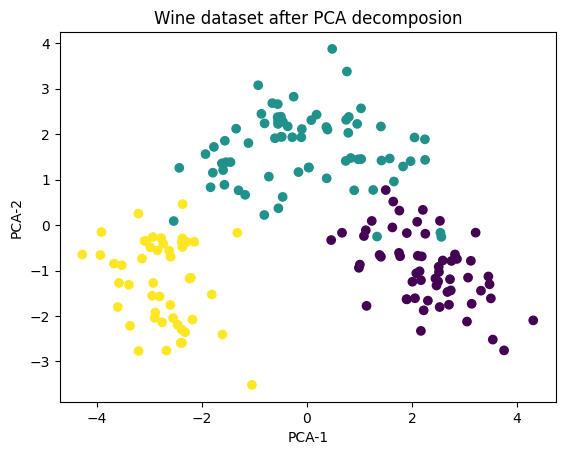

In [3]:
pca = PCA(n_components=2).fit_transform(X_scaled)

plt.scatter(pca[:,0], pca[:,1], c=Y)
plt.title('Wine dataset after PCA decomposion')
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.show()

In [4]:
objective_func_vals = []

def callback_graph(weights, obj_func_eval):
  clear_output(wait=True)
  objective_func_vals.append(obj_func_eval)
  plt.title("Objective function value against iteration")
  plt.xlabel("Iteration")
  plt.ylabel("Objective function value")
  plt.plot(range(len(objective_func_vals)), objective_func_vals)
  plt.show()

# **EfficientSU2 RealAmplitude Test**

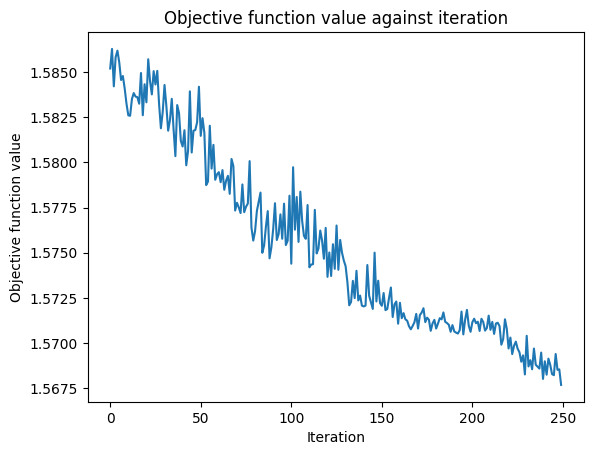

Time:
 [5293.310708284378, 5642.990312576294, 5901.552375078201, 5685.3611536026, 5437.826009750366]
Precision:
 [0.383203601953602, 0.3968253968253968, 0.46825396825396826, 0.41666666666666674, 0.24848484848484853]
Accuracy:
 [0.3888888888888889, 0.3611111111111111, 0.4444444444444444, 0.4166666666666667, 0.25]
Recalls:
 [0.3888888888888889, 0.3611111111111111, 0.4444444444444444, 0.4166666666666667, 0.25]
F1:
 [0.3847736625514403, 0.3611111111111111, 0.44323232323232326, 0.4111111111111111, 0.24783312047679867]


In [12]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(5):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 250
  num_qubits = X.shape[1]
  opt = COBYLA(maxiter=MAXITR)

  featuremap = ZZFeatureMap(feature_dimension=num_qubits, reps=1, parameter_prefix='x')
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=3)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  score = vqc.score(X_test, Y_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='weighted')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Time:\n",times)
  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)

Time:
 [5293.310708284378, 5642.990312576294, 5901.552375078201, 5685.3611536026, 5437.826009750366]
Precision:
 [0.383203601953602, 0.3968253968253968, 0.46825396825396826, 0.41666666666666674, 0.24848484848484853]
Accuracy:
 [0.3888888888888889, 0.3611111111111111, 0.4444444444444444, 0.4166666666666667, 0.25]
Recalls:
 [0.3888888888888889, 0.3611111111111111, 0.4444444444444444, 0.4166666666666667, 0.25]
F1:
 [0.3847736625514403, 0.3611111111111111, 0.44323232323232326, 0.4111111111111111, 0.24783312047679867]

Precision:
 0.3560606060606061
Accuracy:
 0.3333333333333333
Recalls:
 0.3333333333333333
F1:
 0.34122807017543866


In [11]:
print("Time:\n",time)
print("Precision:\n",precision)
print("Accuracy:\n",accuracy)
print("Recalls:\n",recall)
print("F1:\n",f1)

Time:
 <module 'time' (built-in)>
Precision:
 0.3560606060606061
Accuracy:
 0.3333333333333333
Recalls:
 0.3333333333333333
F1:
 0.34122807017543866


In [ ]:
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 250
  num_qubits = X.shape[1]
  opt = COBYLA(maxiter=MAXITR)

  featuremap = ZZFeatureMap(feature_dimension=num_qubits, reps=1, parameter_prefix='x')
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=4)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  score = vqc.score(X_test, Y_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='weighted')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Time:\n",times)
  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)

In [ ]:
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)


  MAXITR = 200
  num_qubits = X.shape[1]
  opt = COBYLA(maxiter=MAXITR)

  featuremap = ZFeatureMap(feature_dimension=num_qubits, reps=0, parameter_prefix='x')
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=3)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  score = vqc.score(X_test, Y_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='weighted')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Time:\n",times)
  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)

# **EfficientSU2 RealAmplitude**

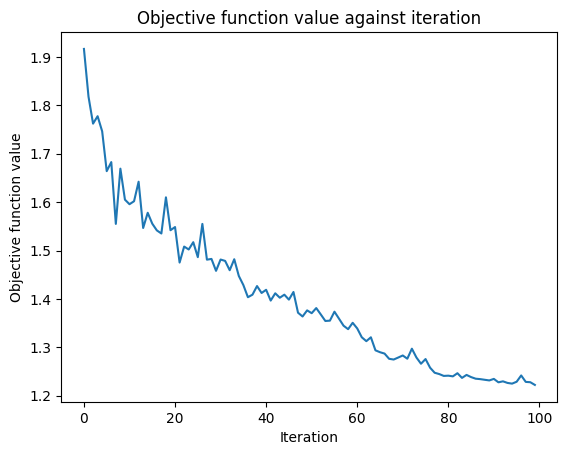

Precision:
 [0.6214424951267056, 0.7377104377104378, 0.700925925925926, 0.8037037037037037, 0.8164983164983164, 0.8213675213675214, 0.7646335146335147, 0.7377104377104378, 0.7453703703703703, 0.7250000000000001]
Accuracy:
 [0.6388888888888888, 0.7222222222222222, 0.6944444444444444, 0.7777777777777778, 0.8055555555555556, 0.8055555555555556, 0.75, 0.7222222222222222, 0.7222222222222222, 0.7222222222222222]
Recall:
 [0.5654761904761905, 0.7440476190476191, 0.6309523809523809, 0.8095238095238096, 0.8333333333333334, 0.7976190476190476, 0.7678571428571429, 0.7440476190476191, 0.6547619047619048, 0.7440476190476191]
F1:
 [0.5987228607918264, 0.7180211064058614, 0.6776437070554718, 0.7749999999999999, 0.8036611323967646, 0.8106995884773662, 0.7509538328251779, 0.7180211064058614, 0.6987567987567989, 0.7198480531813866]
Time:
 [44.73607587814331, 45.182942628860474, 45.09380078315735, 44.72313833236694, 45.28283071517944, 44.89192199707031, 44.825681924819946, 45.16391682624817, 44.833934307

In [14]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 100
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=1)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)


**Precision:**
 [0.6214424951267056, 0.7377104377104378, 0.700925925925926, 0.8037037037037037, 0.8164983164983164, 0.8213675213675214, 0.7646335146335147, 0.7377104377104378, 0.7453703703703703, 0.7250000000000001]
**Mean Precision**
0.7474362723046933±0.057

**Accuracy:**
 [0.6388888888888888, 0.7222222222222222, 0.6944444444444444, 0.7777777777777778, 0.8055555555555556, 0.8055555555555556, 0.75, 0.7222222222222222, 0.7222222222222222, 0.7222222222222222]
**Mean Accuracy**
0.7361111111111112±0.0485

**Recall:**
 [0.5654761904761905, 0.7440476190476191, 0.6309523809523809, 0.8095238095238096, 0.8333333333333334, 0.7976190476190476, 0.7678571428571429, 0.7440476190476191, 0.6547619047619048, 0.7440476190476191]
**Mean Recall**
0.7291666666666666±0.081

**F1:**
 [0.5987228607918264, 0.7180211064058614, 0.6776437070554718, 0.7749999999999999, 0.8036611323967646, 0.8106995884773662, 0.7509538328251779, 0.7180211064058614, 0.6987567987567989, 0.7198480531813866]
**Mean F1**
 0.7271328186296515±0.06
 
**Time:**
 [44.73607587814331, 45.182942628860474, 45.09380078315735, 44.72313833236694, 45.28283071517944, 44.89192199707031, 44.825681924819946, 45.16391682624817, 44.83393430709839, 45.07991600036621]
**Mean Time**
44.98141593933106±0.19183722560274505


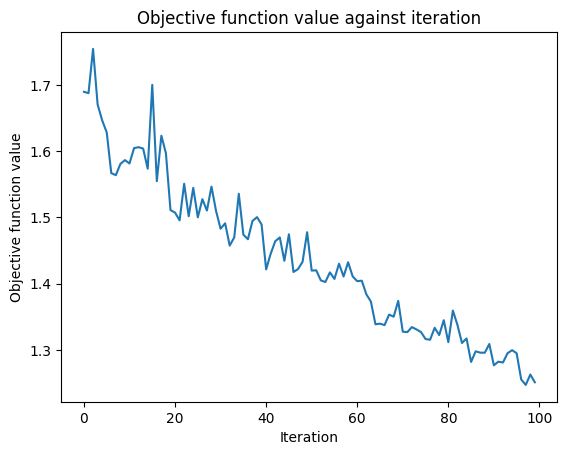

Precision:
 [0.7281576448243116, 0.7396534792368126, 0.691358024691358, 0.8475783475783476, 0.826071169208424, 0.7768389018389018, 0.7231481481481481, 0.9145299145299144, 0.7930021367521367, 0.858974358974359]
Accuracy:
 [0.7222222222222222, 0.7222222222222222, 0.5833333333333334, 0.8055555555555556, 0.6944444444444444, 0.75, 0.6944444444444444, 0.8611111111111112, 0.7222222222222222, 0.8055555555555556]
Recall:
 [0.7083333333333334, 0.7261904761904763, 0.625, 0.8154761904761904, 0.7202380952380952, 0.75, 0.6666666666666666, 0.8809523809523809, 0.7619047619047619, 0.8333333333333334]
F1:
 [0.7243403534253209, 0.7141028900754302, 0.593088071348941, 0.8146502057613169, 0.7190499194847021, 0.7574765498742109, 0.7056030389363723, 0.8705087505087504, 0.7137566137566138, 0.8069933287324592]
Time:
 [52.816195249557495, 52.510732650756836, 52.81733536720276, 52.360251665115356, 52.5595862865448, 52.17078900337219, 52.21463871002197, 52.171632289886475, 52.5647656917572, 61.878737449645996]


In [15]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 100
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=2)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

**Precision:**
 [0.7281576448243116, 0.7396534792368126, 0.691358024691358, 0.8475783475783476, 0.826071169208424, 0.7768389018389018, 0.7231481481481481, 0.9145299145299144, 0.7930021367521367, 0.858974358974359]
**Mean Precision**
0.7899312125782714±0.0675

**Accuracy:**
 [0.7222222222222222, 0.7222222222222222, 0.5833333333333334, 0.8055555555555556, 0.6944444444444444, 0.75, 0.6944444444444444, 0.8611111111111112, 0.7222222222222222, 0.8055555555555556]
**Mean Accuracy**
0.736111111111111±0.07

**Recall:**
 [0.7083333333333334, 0.7261904761904763, 0.625, 0.8154761904761904, 0.7202380952380952, 0.75, 0.6666666666666666, 0.8809523809523809, 0.7619047619047619, 0.8333333333333334]
**Mean Recall**
0.7488095238095237±0.07

**F1:**
 [0.7243403534253209, 0.7141028900754302, 0.593088071348941, 0.8146502057613169, 0.7190499194847021, 0.7574765498742109, 0.7056030389363723, 0.8705087505087504, 0.7137566137566138, 0.8069933287324592]
**Mean F1**
0.7419569721904117±0.07

**Time:**
 [52.816195249557495, 52.510732650756836, 52.81733536720276, 52.360251665115356, 52.5595862865448, 52.17078900337219, 52.21463871002197, 52.171632289886475, 52.5647656917572, 61.878737449645996]
**Mean Time**
53.40646643638611±2.8331891840115353


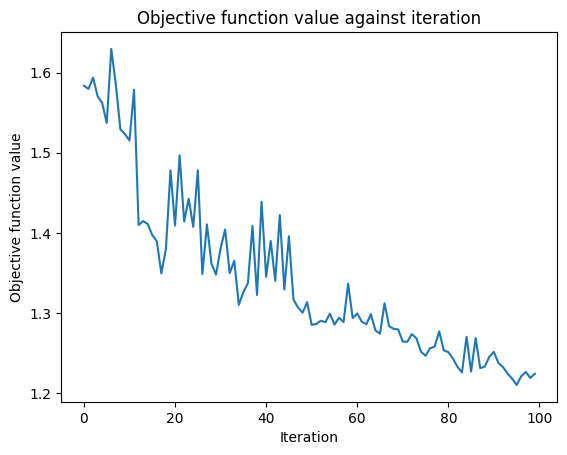

Precision:
 [0.7790775401069517, 0.8391203703703703, 0.8048128342245989, 0.7444919278252612, 0.8529411764705882, 0.7905982905982907, 0.7393162393162394, 0.7133986928104575, 0.861111111111111, 0.8352326685660019]
Accuracy:
 [0.75, 0.8333333333333334, 0.75, 0.7222222222222222, 0.8333333333333334, 0.7222222222222222, 0.7222222222222222, 0.7222222222222222, 0.8333333333333334, 0.8333333333333334]
Recall:
 [0.7678571428571429, 0.8214285714285715, 0.7678571428571428, 0.6904761904761904, 0.8035714285714285, 0.7261904761904763, 0.7083333333333334, 0.6726190476190476, 0.8571428571428571, 0.8392857142857143]
F1:
 [0.7373823120851983, 0.8327635327635328, 0.7476462417039667, 0.720985675846787, 0.8304383788254756, 0.7391240446796002, 0.7283950617283951, 0.7091949269368624, 0.8358974358974359, 0.8332122972645848]
Time:
 [76.32098650932312, 75.27909421920776, 75.73418712615967, 75.87146735191345, 76.82432293891907, 77.38650250434875, 76.24178504943848, 75.9535825252533, 76.1426293849945, 76.709034442

In [16]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 100
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=3)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

**Precision:**
 [0.7790775401069517, 0.8391203703703703, 0.8048128342245989, 0.7444919278252612, 0.8529411764705882, 0.7905982905982907, 0.7393162393162394, 0.7133986928104575, 0.861111111111111, 0.8352326685660019]
**Mean Precision**
0.7960100851399871±0.049

**Accuracy:**
 [0.75, 0.8333333333333334, 0.75, 0.7222222222222222, 0.8333333333333334, 0.7222222222222222, 0.7222222222222222, 0.7222222222222222, 0.8333333333333334, 0.8333333333333334]
**Mean Accuracy**
0.7722222222222221±0.05

**Recall:**
 [0.7678571428571429, 0.8214285714285715, 0.7678571428571428, 0.6904761904761904, 0.8035714285714285, 0.7261904761904763, 0.7083333333333334, 0.6726190476190476, 0.8571428571428571, 0.8392857142857143]
**Mean Recall**
0.7654761904761904±0.061

**F1:**
 [0.7373823120851983, 0.8327635327635328, 0.7476462417039667, 0.720985675846787, 0.8304383788254756, 0.7391240446796002, 0.7283950617283951, 0.7091949269368624, 0.8358974358974359, 0.8332122972645848]
**Mean F1**
0.7715039907731838±0.051

**Time:**
 [76.32098650932312, 75.27909421920776, 75.73418712615967, 75.87146735191345, 76.82432293891907, 77.38650250434875, 76.24178504943848, 75.9535825252533, 76.1426293849945, 76.70903444290161]
**Mean Time**
76.24635920524597±0.5734606443643983



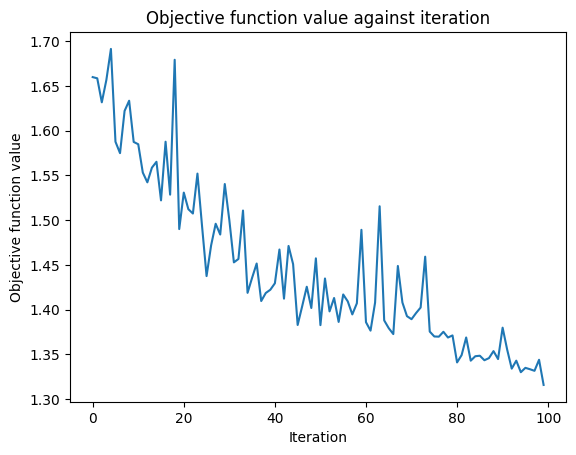

Precision:
 [0.7942760942760942, 0.6715399610136452, 0.7627314814814814, 0.7833333333333333, 0.7000000000000001, 0.7583333333333333, 0.7671156004489338, 0.8962962962962963, 0.7374465811965812, 0.7953897953897954]
Accuracy:
 [0.7777777777777778, 0.6666666666666666, 0.75, 0.7777777777777778, 0.5833333333333334, 0.6666666666666666, 0.6944444444444444, 0.8055555555555556, 0.6944444444444444, 0.7777777777777778]
Recall:
 [0.7916666666666666, 0.6071428571428571, 0.7321428571428571, 0.7738095238095237, 0.625, 0.6964285714285715, 0.7380952380952381, 0.8333333333333334, 0.7380952380952381, 0.8095238095238096]
F1:
 [0.7789697743720733, 0.6414141414141414, 0.7531339031339032, 0.7778471247031086, 0.5831584207896052, 0.6805555555555556, 0.6959742351046699, 0.8119032515167781, 0.6767195767195767, 0.7746502057613169]
Time:
 [86.75473022460938, 71.71454548835754, 67.17946887016296, 66.76259326934814, 67.61312699317932, 67.66738533973694, 67.39995288848877, 67.85497641563416, 67.81648087501526, 67.6350

In [17]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 100
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=4)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

**Precision:**
 [0.7942760942760942, 0.6715399610136452, 0.7627314814814814, 0.7833333333333333, 0.7000000000000001, 0.7583333333333333, 0.7671156004489338, 0.8962962962962963, 0.7374465811965812, 0.7953897953897954]
**Mean Precision**
0.7666462476769494±0.0575

**Accuracy:**
 [0.7777777777777778, 0.6666666666666666, 0.75, 0.7777777777777778, 0.5833333333333334, 0.6666666666666666, 0.6944444444444444, 0.8055555555555556, 0.6944444444444444, 0.7777777777777778]
**Mean Accuracy**
0.7194444444444444±0.066

**Recall:**
 [0.7916666666666666, 0.6071428571428571, 0.7321428571428571, 0.7738095238095237, 0.625, 0.6964285714285715, 0.7380952380952381, 0.8333333333333334, 0.7380952380952381, 0.8095238095238096]
**Mean Recall**
0.7345238095238095±0.07

**F1:**
 [0.7789697743720733, 0.6414141414141414, 0.7531339031339032, 0.7778471247031086, 0.5831584207896052, 0.6805555555555556, 0.6959742351046699, 0.8119032515167781, 0.6767195767195767, 0.7746502057613169]
**Mean F1**
0.7174326189070729±0.069

**Time:**
 [86.75473022460938, 71.71454548835754, 67.17946887016296, 66.76259326934814, 67.61312699317932, 67.66738533973694, 67.39995288848877, 67.85497641563416, 67.81648087501526, 67.63500785827637]
**Mean Time**
69.83982682228088±5.785333728659437



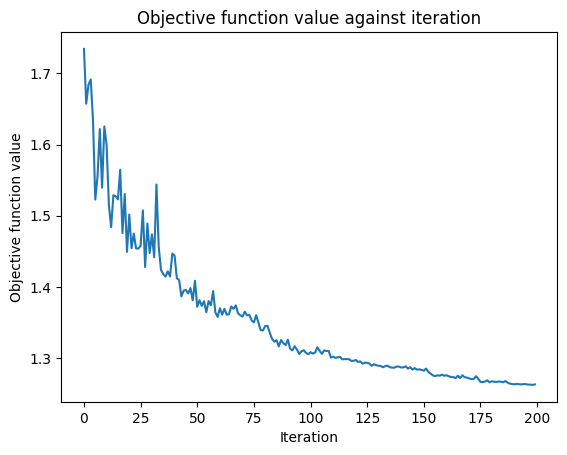

Precision:
 [0.7759081196581197, 0.8339506172839506, 0.7268518518518519, 0.8492063492063492, 0.7858796296296297, 0.8728395061728396, 0.8658119658119658, 0.8453703703703703, 0.8675925925925926, 0.7268518518518519]
Accuracy:
 [0.6944444444444444, 0.8333333333333334, 0.6944444444444444, 0.7777777777777778, 0.7222222222222222, 0.8611111111111112, 0.8611111111111112, 0.8333333333333334, 0.8611111111111112, 0.6666666666666666]
Recall:
 [0.7202380952380952, 0.8392857142857143, 0.7023809523809524, 0.8095238095238094, 0.7440476190476191, 0.8630952380952381, 0.8809523809523809, 0.8392857142857143, 0.8809523809523809, 0.7142857142857143]
F1:
 [0.6925925925925926, 0.8308108389244293, 0.7017094017094017, 0.7777777777777778, 0.7235690235690236, 0.8638199753818416, 0.8600823045267489, 0.8352326685660019, 0.8599240265906932, 0.6594146594146593]
Time:
 [157.6887183189392, 159.0414764881134, 136.8200535774231, 160.45677137374878, 152.4491515159607, 154.19775128364563, 158.89716267585754, 157.55722141265

In [6]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 200
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=2)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
  
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.7759081196581197, 0.8339506172839506, 0.7268518518518519, 0.8492063492063492, 0.7858796296296297, 0.8728395061728396, 0.8658119658119658, 0.8453703703703703, 0.8675925925925926, 0.7268518518518519]
Accuracy:
 [0.6944444444444444, 0.8333333333333334, 0.6944444444444444, 0.7777777777777778, 0.7222222222222222, 0.8611111111111112, 0.8611111111111112, 0.8333333333333334, 0.8611111111111112, 0.6666666666666666]
Recall:
 [0.7202380952380952, 0.8392857142857143, 0.7023809523809524, 0.8095238095238094, 0.7440476190476191, 0.8630952380952381, 0.8809523809523809, 0.8392857142857143, 0.8809523809523809, 0.7142857142857143]
F1:
 [0.6925925925925926, 0.8308108389244293, 0.7017094017094017, 0.7777777777777778, 0.7235690235690236, 0.8638199753818416, 0.8600823045267489, 0.8352326685660019, 0.8599240265906932, 0.6594146594146593]
Time:
 [157.6887183189392, 159.0414764881134, 136.8200535774231, 160.45677137374878, 152.4491515159607, 154.19775128364563, 158.89716267585754, 157.5572214126587, 183.12195253372192, 185.66141748428345]
Mean Precision: 0.8150262854429521±0.0539084046984603
Mean Accuracy: 0.7805555555555557±0.07500000000000004
Mean Recall: 0.799404761904762±0.06828654861016505
Mean F1: 0.7804933269053171±0.07546950344317474
Mean Time: 160.58916766643523±13.532575578365558


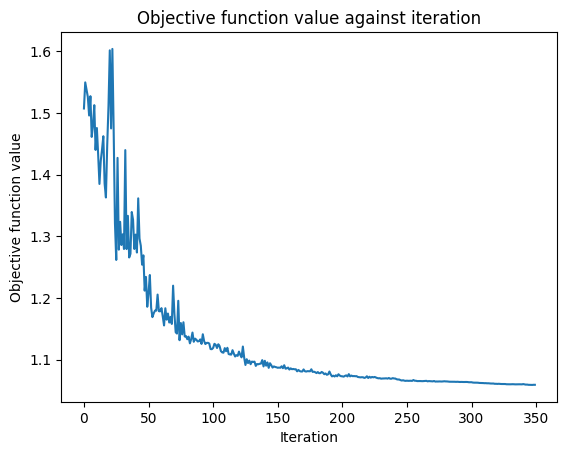

Precision:
 [0.780911680911681, 0.7458791208791209, 0.7947118241235889, 0.8147500647500647, 0.7991452991452992, 0.8179012345679012, 0.7648148148148148, 0.6743827160493827, 0.7882716049382715, 0.7790080290080291]
Accuracy:
 [0.7777777777777778, 0.75, 0.7777777777777778, 0.8055555555555556, 0.75, 0.7777777777777778, 0.75, 0.6666666666666666, 0.7222222222222222, 0.75]
Recall:
 [0.7738095238095237, 0.6964285714285715, 0.7738095238095237, 0.8333333333333334, 0.75, 0.7738095238095238, 0.7857142857142857, 0.6607142857142857, 0.7619047619047619, 0.7857142857142857]
F1:
 [0.7785582517383283, 0.745679012345679, 0.7788530465949821, 0.8031522300528148, 0.7636213991769548, 0.7771827934072181, 0.7425925925925926, 0.6681489571956104, 0.724266072092159, 0.7484574684574685]
Time:
 [311.1585063934326, 255.03251266479492, 213.39250016212463, 228.96563529968262, 312.2219338417053, 332.3385133743286, 312.91119408607483, 307.01017117500305, 300.11864376068115, 279.1121680736542]
Mean Precision: 0.7759776389

In [7]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 350
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=3)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
  
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.780911680911681, 0.7458791208791209, 0.7947118241235889, 0.8147500647500647, 0.7991452991452992, 0.8179012345679012, 0.7648148148148148, 0.6743827160493827, 0.7882716049382715, 0.7790080290080291]
Accuracy:
 [0.7777777777777778, 0.75, 0.7777777777777778, 0.8055555555555556, 0.75, 0.7777777777777778, 0.75, 0.6666666666666666, 0.7222222222222222, 0.75]
Recall:
 [0.7738095238095237, 0.6964285714285715, 0.7738095238095237, 0.8333333333333334, 0.75, 0.7738095238095238, 0.7857142857142857, 0.6607142857142857, 0.7619047619047619, 0.7857142857142857]
F1:
 [0.7785582517383283, 0.745679012345679, 0.7788530465949821, 0.8031522300528148, 0.7636213991769548, 0.7771827934072181, 0.7425925925925926, 0.6681489571956104, 0.724266072092159, 0.7484574684574685]
Time:
 [311.1585063934326, 255.03251266479492, 213.39250016212463, 228.96563529968262, 312.2219338417053, 332.3385133743286, 312.91119408607483, 307.01017117500305, 300.11864376068115, 279.1121680736542]
 
Mean Precision: 0.7759776389188154±0.039604704860181306
Mean Accuracy: 0.7527777777777778±0.03611111111111113
Mean Recall: 0.7595238095238095±0.04612231101859646
Mean F1: 0.7530511823653808±0.03569639969316011
Mean Time: 285.2261778831482±37.89192674563356


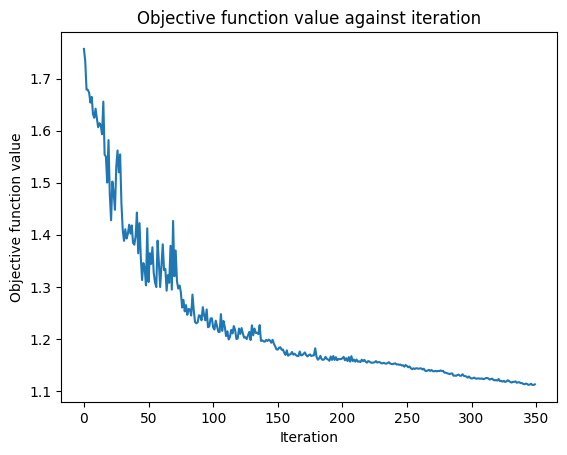

Precision:
 [0.7777777777777779, 0.8314814814814815, 0.8411172161172161, 0.925925925925926, 0.7808641975308642, 0.7899167109693426, 0.9069865319865319, 0.7745935981230098, 0.8340548340548339, 0.8176557239057238]
Accuracy:
 [0.75, 0.75, 0.8333333333333334, 0.8888888888888888, 0.7222222222222222, 0.7777777777777778, 0.8888888888888888, 0.7777777777777778, 0.7777777777777778, 0.8055555555555556]
Recall:
 [0.7678571428571429, 0.7857142857142857, 0.8214285714285715, 0.9047619047619048, 0.7083333333333334, 0.7559523809523809, 0.9047619047619048, 0.7380952380952381, 0.8095238095238096, 0.7976190476190476]
F1:
 [0.7538461538461538, 0.758082497212932, 0.8345679012345679, 0.8944855967078189, 0.722257295173962, 0.7686964886964888, 0.8906799286916246, 0.7700214295196374, 0.7838383838383839, 0.8050108932461875]
Time:
 [347.12161350250244, 286.90353989601135, 263.5774738788605, 256.0851500034332, 268.6017396450043, 289.6581699848175, 289.1336042881012, 315.86271619796753, 244.51508331298828, 234.868

In [8]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 350
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=4)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
  
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.7777777777777779, 0.8314814814814815, 0.8411172161172161, 0.925925925925926, 0.7808641975308642, 0.7899167109693426, 0.9069865319865319, 0.7745935981230098, 0.8340548340548339, 0.8176557239057238]
Accuracy:
 [0.75, 0.75, 0.8333333333333334, 0.8888888888888888, 0.7222222222222222, 0.7777777777777778, 0.8888888888888888, 0.7777777777777778, 0.7777777777777778, 0.8055555555555556]
Recall:
 [0.7678571428571429, 0.7857142857142857, 0.8214285714285715, 0.9047619047619048, 0.7083333333333334, 0.7559523809523809, 0.9047619047619048, 0.7380952380952381, 0.8095238095238096, 0.7976190476190476]
F1:
 [0.7538461538461538, 0.758082497212932, 0.8345679012345679, 0.8944855967078189, 0.722257295173962, 0.7686964886964888, 0.8906799286916246, 0.7700214295196374, 0.7838383838383839, 0.8050108932461875]
Time:
 [347.12161350250244, 286.90353989601135, 263.5774738788605, 256.0851500034332, 268.6017396450043, 289.6581699848175, 289.1336042881012, 315.86271619796753, 244.51508331298828, 234.868145942688]
Mean Precision: 0.8280373997872708±0.05020241876222019
Mean Accuracy: 0.7972222222222223±0.05422005915539759
Mean Recall: 0.799404761904762±0.06157478446273809
Mean F1: 0.7981486568167756±0.05514268458926651
Mean Time: 279.63272366523745±32.06565397379309


# **EfficientSU2+Hadamrd/RealAmplitudes**

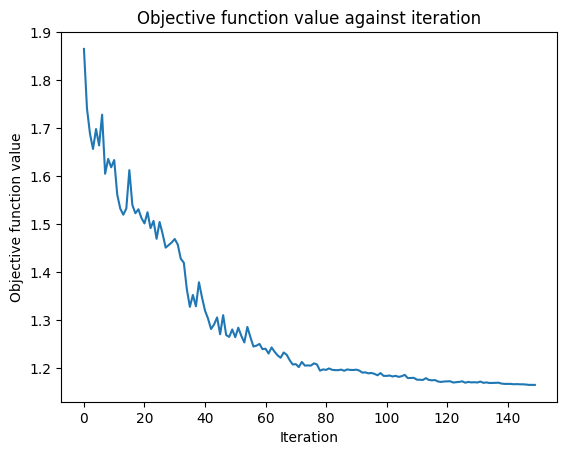

Precision:
 [0.6431327160493827, 0.6607744107744107, 0.873148148148148, 0.7179549114331722, 0.6925925925925926, 0.6071895424836602, 0.5787811222593832, 0.7633406432748537, 0.5652777777777778, 0.7010466988727857]
Accuracy:
 [0.6666666666666666, 0.6111111111111112, 0.8611111111111112, 0.6666666666666666, 0.6944444444444444, 0.6111111111111112, 0.6944444444444444, 0.6944444444444444, 0.5555555555555556, 0.6388888888888888]
Recall:
 [0.5892857142857143, 0.5595238095238095, 0.8630952380952381, 0.6071428571428572, 0.6666666666666666, 0.5773809523809524, 0.5952380952380952, 0.6130952380952381, 0.5476190476190476, 0.5833333333333334]
F1:
 [0.6245370370370371, 0.5984624017957353, 0.8630104463437797, 0.6457480207480207, 0.6902025177887248, 0.6007719878687621, 0.6189522856189522, 0.645679012345679, 0.5524691358024691, 0.6247269997269997]
Time:
 [95.03278732299805, 96.7872793674469, 97.11449670791626, 95.16651773452759, 95.38329291343689, 95.69643115997314, 98.1427710056305, 97.38989567756653, 96.

In [7]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 150
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)
    
  qc_init = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
    qc_init.h(i)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x'
                           ,initial_state=qc_init)
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=1)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
  
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.6431327160493827, 0.6607744107744107, 0.873148148148148, 0.7179549114331722, 0.6925925925925926, 0.6071895424836602, 0.5787811222593832, 0.7633406432748537, 0.5652777777777778, 0.7010466988727857]
Accuracy:
 [0.6666666666666666, 0.6111111111111112, 0.8611111111111112, 0.6666666666666666, 0.6944444444444444, 0.6111111111111112, 0.6944444444444444, 0.6944444444444444, 0.5555555555555556, 0.6388888888888888]
Recall:
 [0.5892857142857143, 0.5595238095238095, 0.8630952380952381, 0.6071428571428572, 0.6666666666666666, 0.5773809523809524, 0.5952380952380952, 0.6130952380952381, 0.5476190476190476, 0.5833333333333334]
F1:
 [0.6245370370370371, 0.5984624017957353, 0.8630104463437797, 0.6457480207480207, 0.6902025177887248, 0.6007719878687621, 0.6189522856189522, 0.645679012345679, 0.5524691358024691, 0.6247269997269997]
Time:
 [95.03278732299805, 96.7872793674469, 97.11449670791626, 95.16651773452759, 95.38329291343689, 95.69643115997314, 98.1427710056305, 97.38989567756653, 96.56689929962158, 99.81912279129028]
Mean Precision: 0.6803238563666166±0.08759541395643279
Mean Accuracy: 0.6694444444444445±0.0770301367992336
Mean Recall: 0.6202380952380951±0.08665979826263524
Mean F1: 0.646455984507616±0.07983963975620668
Mean Time: 96.70994939804078±1.4266974537439643


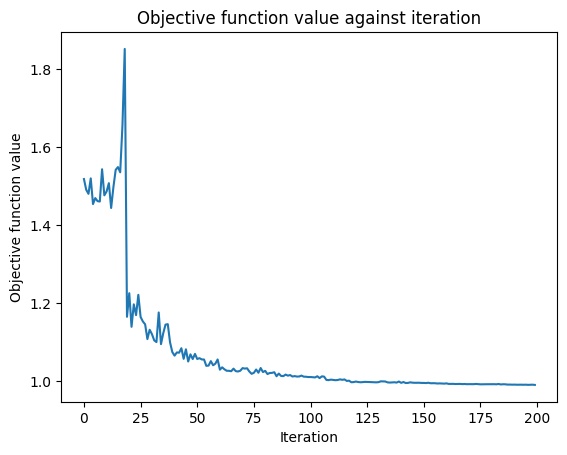

Precision:
 [0.6763029998324116, 0.9135802469135802, 0.8976608187134504, 0.838888888888889, 0.8976608187134504, 0.8215277777777779, 0.8675925925925926, 0.7775403608736942, 0.7226430976430975, 0.9313725490196079]
Accuracy:
 [0.6666666666666666, 0.8888888888888888, 0.8611111111111112, 0.8333333333333334, 0.8611111111111112, 0.8055555555555556, 0.8611111111111112, 0.7777777777777778, 0.7222222222222222, 0.9166666666666666]
Recall:
 [0.6964285714285715, 0.8690476190476191, 0.8273809523809524, 0.8392857142857143, 0.8273809523809524, 0.8154761904761906, 0.8809523809523809, 0.7916666666666666, 0.7261904761904762, 0.9107142857142857]
F1:
 [0.6298685782556751, 0.8897283272283273, 0.8598808598808598, 0.8348020434227331, 0.8598808598808598, 0.8015432098765432, 0.8599240265906932, 0.7766279351246673, 0.7168627450980393, 0.9176362466685047]
Time:
 [144.33553671836853, 147.91306257247925, 145.9949231147766, 147.35167932510376, 146.30594158172607, 145.4863166809082, 122.47795748710632, 132.3339672088

In [9]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 200
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)
    
  qc_init = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
    qc_init.h(i)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x'
                           ,initial_state=qc_init)
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=2)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
  
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.6763029998324116, 0.9135802469135802, 0.8976608187134504, 0.838888888888889, 0.8976608187134504, 0.8215277777777779, 0.8675925925925926, 0.7775403608736942, 0.7226430976430975, 0.9313725490196079]
Accuracy:
 [0.6666666666666666, 0.8888888888888888, 0.8611111111111112, 0.8333333333333334, 0.8611111111111112, 0.8055555555555556, 0.8611111111111112, 0.7777777777777778, 0.7222222222222222, 0.9166666666666666]
Recall:
 [0.6964285714285715, 0.8690476190476191, 0.8273809523809524, 0.8392857142857143, 0.8273809523809524, 0.8154761904761906, 0.8809523809523809, 0.7916666666666666, 0.7261904761904762, 0.9107142857142857]
F1:
 [0.6298685782556751, 0.8897283272283273, 0.8598808598808598, 0.8348020434227331, 0.8598808598808598, 0.8015432098765432, 0.8599240265906932, 0.7766279351246673, 0.7168627450980393, 0.9176362466685047]
Time:
 [144.33553671836853, 147.91306257247925, 145.9949231147766, 147.35167932510376, 146.30594158172607, 145.4863166809082, 122.47795748710632, 132.3339672088623, 161.1745891571045, 198.85681223869324]
 
Mean Precision: 0.8344770150968552±0.08104435051216322
Mean Accuracy: 0.8194444444444444±0.07375510026306531
Mean Recall: 0.818452380952381±0.06300813844420482
Mean F1: 0.8146754832026902±0.08253145209260747
Mean Time: 149.22307860851288±19.154347065828734


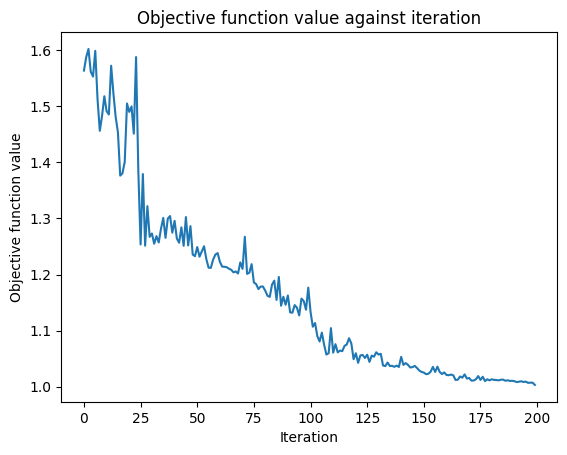

Precision:
 [0.8009259259259259, 0.7981532356532357, 0.805026455026455, 0.9277777777777777, 0.7973856209150326, 0.8334656084656084, 0.7709876543209878, 0.8111271444604778, 0.7451566951566951, 0.9444444444444444]
Accuracy:
 [0.8055555555555556, 0.8055555555555556, 0.8055555555555556, 0.9166666666666666, 0.7777777777777778, 0.7777777777777778, 0.7222222222222222, 0.8055555555555556, 0.75, 0.9444444444444444]
Recall:
 [0.7619047619047619, 0.7797619047619048, 0.7797619047619048, 0.9285714285714285, 0.7559523809523809, 0.8095238095238096, 0.6726190476190476, 0.7976190476190476, 0.7321428571428572, 0.9345238095238096]
F1:
 [0.7992063492063493, 0.7991769547325103, 0.8042784163473818, 0.9176163342830009, 0.7748828232699201, 0.7823426573426574, 0.7104123127830025, 0.7980555555555556, 0.7468071519795658, 0.9444444444444444]
Time:
 [191.31912636756897, 173.9035222530365, 176.49025917053223, 170.6501898765564, 202.33009243011475, 214.39738941192627, 201.2121467590332, 206.98196387290955, 202.00912

In [10]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 200
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)
    
  qc_init = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
    qc_init.h(i)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x'
                           ,initial_state=qc_init)
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=3)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
  
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.8009259259259259, 0.7981532356532357, 0.805026455026455, 0.9277777777777777, 0.7973856209150326, 0.8334656084656084, 0.7709876543209878, 0.8111271444604778, 0.7451566951566951, 0.9444444444444444]
Accuracy:
 [0.8055555555555556, 0.8055555555555556, 0.8055555555555556, 0.9166666666666666, 0.7777777777777778, 0.7777777777777778, 0.7222222222222222, 0.8055555555555556, 0.75, 0.9444444444444444]
Recall:
 [0.7619047619047619, 0.7797619047619048, 0.7797619047619048, 0.9285714285714285, 0.7559523809523809, 0.8095238095238096, 0.6726190476190476, 0.7976190476190476, 0.7321428571428572, 0.9345238095238096]
F1:
 [0.7992063492063493, 0.7991769547325103, 0.8042784163473818, 0.9176163342830009, 0.7748828232699201, 0.7823426573426574, 0.7104123127830025, 0.7980555555555556, 0.7468071519795658, 0.9444444444444444]
Time:
 [191.31912636756897, 173.9035222530365, 176.49025917053223, 170.6501898765564, 202.33009243011475, 214.39738941192627, 201.2121467590332, 206.98196387290955, 202.00912189483643, 207.8180592060089]
 
Mean Precision: 0.8234450562146641±0.0606830158305117
Mean Accuracy: 0.8111111111111111±0.06549903401417552
Mean Recall: 0.7952380952380952±0.07716085915761337
Mean F1: 0.8077222999944389±0.06776646703403671
Mean Time: 194.71118712425232±14.89589695876262


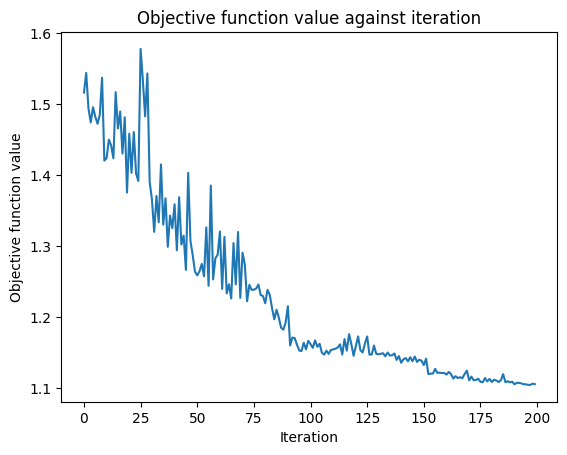

Precision:
 [0.8623931623931624, 0.8411172161172161, 0.8958333333333334, 0.8228988603988604, 0.8869281045751634, 0.9145299145299144, 0.8962962962962963, 0.8119358854652973, 0.8929249762583097, 0.974074074074074]
Accuracy:
 [0.8611111111111112, 0.8333333333333334, 0.8888888888888888, 0.7777777777777778, 0.8611111111111112, 0.8611111111111112, 0.8055555555555556, 0.8055555555555556, 0.8888888888888888, 0.9722222222222222]
Recall:
 [0.8809523809523809, 0.8214285714285715, 0.8690476190476191, 0.7916666666666666, 0.8809523809523809, 0.8809523809523809, 0.8333333333333334, 0.7976190476190476, 0.8869047619047619, 0.9761904761904763]
F1:
 [0.8609337306655315, 0.8345679012345679, 0.8867724867724868, 0.7711018228259608, 0.8531331705712257, 0.8705087505087504, 0.8179115570419918, 0.8030879514750482, 0.8897966594045025, 0.9721867461331064]
Time:
 [206.87658405303955, 213.79116106033325, 218.5781865119934, 213.89839911460876, 224.2123725414276, 165.95293521881104, 225.18731427192688, 212.8074688911

In [11]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 200
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)
    
  qc_init = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
    qc_init.h(i)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x'
                           ,initial_state=qc_init)
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=4)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
  
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.8623931623931624, 0.8411172161172161, 0.8958333333333334, 0.8228988603988604, 0.8869281045751634, 0.9145299145299144, 0.8962962962962963, 0.8119358854652973, 0.8929249762583097, 0.974074074074074]
Accuracy:
 [0.8611111111111112, 0.8333333333333334, 0.8888888888888888, 0.7777777777777778, 0.8611111111111112, 0.8611111111111112, 0.8055555555555556, 0.8055555555555556, 0.8888888888888888, 0.9722222222222222]
Recall:
 [0.8809523809523809, 0.8214285714285715, 0.8690476190476191, 0.7916666666666666, 0.8809523809523809, 0.8809523809523809, 0.8333333333333334, 0.7976190476190476, 0.8869047619047619, 0.9761904761904763]
F1:
 [0.8609337306655315, 0.8345679012345679, 0.8867724867724868, 0.7711018228259608, 0.8531331705712257, 0.8705087505087504, 0.8179115570419918, 0.8030879514750482, 0.8897966594045025, 0.9721867461331064]
Time:
 [206.87658405303955, 213.79116106033325, 218.5781865119934, 213.89839911460876, 224.2123725414276, 165.95293521881104, 225.18731427192688, 212.8074688911438, 189.28683137893677, 185.31368350982666]
 
Mean Precision: 0.8798931823441627±0.04526431830488089
Mean Accuracy: 0.8555555555555555±0.05241100628920334
Mean Recall: 0.8619047619047621±0.05132871699359549
Mean F1: 0.8560000776633172±0.05267735193384568
Mean Time: 205.59049365520477±18.269086973485425


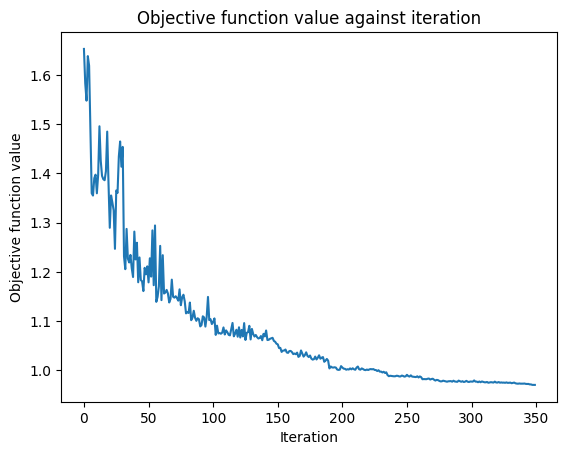

Precision:
 [0.8675925925925926, 0.9116161616161617, 0.9037037037037037, 0.8509259259259259, 0.9277777777777777, 0.8675925925925926, 0.8100118835412953, 0.8703703703703705, 0.8277777777777778, 0.974074074074074]
Accuracy:
 [0.8611111111111112, 0.8888888888888888, 0.8888888888888888, 0.8333333333333334, 0.9166666666666666, 0.8611111111111112, 0.8055555555555556, 0.8611111111111112, 0.8055555555555556, 0.9722222222222222]
Recall:
 [0.8809523809523809, 0.9047619047619048, 0.9047619047619048, 0.8035714285714285, 0.9285714285714285, 0.8809523809523809, 0.8154761904761906, 0.8452380952380952, 0.7976190476190476, 0.9761904761904763]
F1:
 [0.8599240265906932, 0.89046783625731, 0.8884120902511707, 0.8307102858826997, 0.9176163342830009, 0.8599240265906932, 0.8006093189964159, 0.8609742747673783, 0.8126780626780625, 0.9721867461331064]
Time:
 [343.66142773628235, 464.5725622177124, 448.9980368614197, 383.8555471897125, 351.8007597923279, 315.53286957740784, 330.0275619029999, 330.8441741466522, 

In [12]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 350
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)
    
  qc_init = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
    qc_init.h(i)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x'
                           ,initial_state=qc_init)
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=4)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
  
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.8675925925925926, 0.9116161616161617, 0.9037037037037037, 0.8509259259259259, 0.9277777777777777, 0.8675925925925926, 0.8100118835412953, 0.8703703703703705, 0.8277777777777778, 0.974074074074074]
Accuracy:
 [0.8611111111111112, 0.8888888888888888, 0.8888888888888888, 0.8333333333333334, 0.9166666666666666, 0.8611111111111112, 0.8055555555555556, 0.8611111111111112, 0.8055555555555556, 0.9722222222222222]
Recall:
 [0.8809523809523809, 0.9047619047619048, 0.9047619047619048, 0.8035714285714285, 0.9285714285714285, 0.8809523809523809, 0.8154761904761906, 0.8452380952380952, 0.7976190476190476, 0.9761904761904763]
F1:
 [0.8599240265906932, 0.89046783625731, 0.8884120902511707, 0.8307102858826997, 0.9176163342830009, 0.8599240265906932, 0.8006093189964159, 0.8609742747673783, 0.8126780626780625, 0.9721867461331064]
Time:
 [343.66142773628235, 464.5725622177124, 448.9980368614197, 383.8555471897125, 351.8007597923279, 315.53286957740784, 330.0275619029999, 330.8441741466522, 292.937059879303, 298.0323579311371]
 
Mean Precision: 0.881144285997227±0.046424580567770914
Mean Accuracy: 0.8694444444444445±0.048192643258048506
Mean Recall: 0.8738095238095237±0.0551872713642822
Mean F1: 0.8693503002430532±0.04836551416734795
Mean Time: 356.02623572349546±56.271296803901826


# **EfficientSU2 TwoLocal**

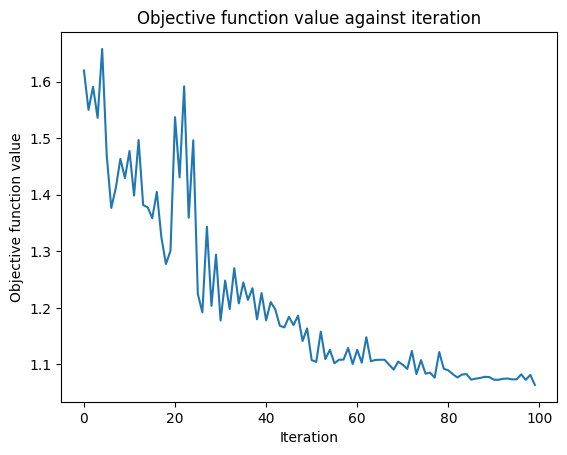

Precision:
 [0.9145299145299144, 0.8796296296296297, 0.8791763791763791, 0.8814814814814815, 0.9145299145299144, 0.9094794094794094, 0.9393939393939394, 0.9145299145299144, 0.8925925925925926, 0.9047619047619047]
Accuracy:
 [0.8611111111111112, 0.8333333333333334, 0.8333333333333334, 0.8611111111111112, 0.8611111111111112, 0.8888888888888888, 0.9166666666666666, 0.8611111111111112, 0.8888888888888888, 0.8333333333333334]
Recall:
 [0.8809523809523809, 0.8392857142857143, 0.8571428571428571, 0.8630952380952381, 0.8809523809523809, 0.9047619047619048, 0.9285714285714285, 0.8809523809523809, 0.8690476190476191, 0.8571428571428571]
F1:
 [0.8705087505087504, 0.8407407407407407, 0.8393976393976393, 0.8637207322264794, 0.8705087505087504, 0.8917878742440146, 0.9182456140350878, 0.8705087505087504, 0.8898112672059033, 0.8460606060606062]
Time:
 [59.767016887664795, 59.46497082710266, 60.181538105010986, 60.010112285614014, 60.26585650444031, 60.00543522834778, 60.2920036315918, 60.1013491153717

In [18]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 100
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=1, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

**Precision:**
 [0.9145299145299144, 0.8796296296296297, 0.8791763791763791, 0.8814814814814815, 0.9145299145299144, 0.9094794094794094, 0.9393939393939394, 0.9145299145299144, 0.8925925925925926, 0.9047619047619047]

**Mean Precision**
0.9030105080105081±0.018

**Accuracy:**
 [0.8611111111111112, 0.8333333333333334, 0.8333333333333334, 0.8611111111111112, 0.8611111111111112, 0.8888888888888888, 0.9166666666666666, 0.8611111111111112, 0.8888888888888888, 0.8333333333333334]

**Mean Accuracy**
 0.8638888888888889±0.026

**Recall:**
 [0.8809523809523809, 0.8392857142857143, 0.8571428571428571, 0.8630952380952381, 0.8809523809523809, 0.9047619047619048, 0.9285714285714285, 0.8809523809523809, 0.8690476190476191, 0.8571428571428571]

**Mean Recall**
0.8761904761904763±0.024

**F1:**
 [0.8705087505087504, 0.8407407407407407, 0.8393976393976393, 0.8637207322264794, 0.8705087505087504, 0.8917878742440146, 0.9182456140350878, 0.8705087505087504, 0.8898112672059033, 0.8460606060606062]

**Mean F1**
0.8701290725436722±0.024


**Time:**
 [59.767016887664795, 59.46497082710266, 60.181538105010986, 60.010112285614014, 60.26585650444031, 60.00543522834778, 60.2920036315918, 60.101349115371704, 60.44071912765503, 59.92348575592041]
 
**Mean Time**
60.04524874687195±0.2682267628666144


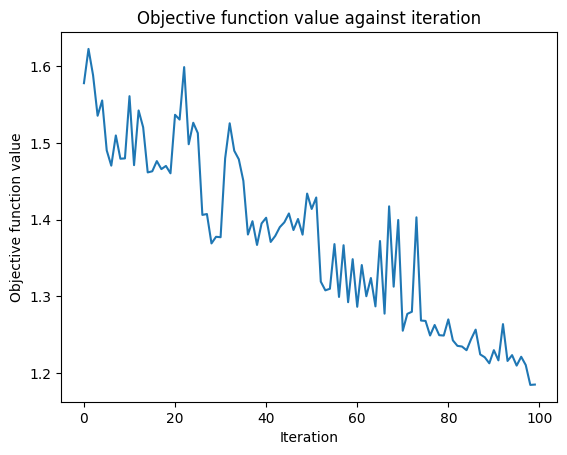

Precision:
 [0.8821225071225071, 0.9145299145299144, 0.8105413105413105, 0.8176638176638177, 0.8425925925925926, 0.8518518518518519, 0.8189542483660132, 0.8888888888888888, 0.7585130918464252, 0.8888888888888888]
Accuracy:
 [0.8333333333333334, 0.8611111111111112, 0.8055555555555556, 0.7777777777777778, 0.8055555555555556, 0.8055555555555556, 0.7777777777777778, 0.8888888888888888, 0.7222222222222222, 0.8888888888888888]
Recall:
 [0.8571428571428571, 0.8809523809523809, 0.7976190476190476, 0.7916666666666666, 0.8333333333333334, 0.8154761904761904, 0.7916666666666666, 0.8690476190476191, 0.7619047619047619, 0.8690476190476191]
F1:
 [0.8405942205942206, 0.8705087505087504, 0.8070685064149116, 0.7858436213991771, 0.8074074074074074, 0.8129629629629629, 0.7782626010770003, 0.8888888888888888, 0.7152035654451113, 0.8888888888888888]
Time:
 [77.82895827293396, 77.63202929496765, 77.3433108329773, 77.90164709091187, 78.07630014419556, 77.8449878692627, 77.91283655166626, 77.39677476882935, 7

In [19]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 100
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=2, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

Precision:
 [0.8821225071225071, 0.9145299145299144, 0.8105413105413105, 0.8176638176638177, 0.8425925925925926, 0.8518518518518519, 0.8189542483660132, 0.8888888888888888, 0.7585130918464252, 0.8888888888888888]
Accuracy:
 [0.8333333333333334, 0.8611111111111112, 0.8055555555555556, 0.7777777777777778, 0.8055555555555556, 0.8055555555555556, 0.7777777777777778, 0.8888888888888888, 0.7222222222222222, 0.8888888888888888]
Recall:
 [0.8571428571428571, 0.8809523809523809, 0.7976190476190476, 0.7916666666666666, 0.8333333333333334, 0.8154761904761904, 0.7916666666666666, 0.8690476190476191, 0.7619047619047619, 0.8690476190476191]
F1:
 [0.8405942205942206, 0.8705087505087504, 0.8070685064149116, 0.7858436213991771, 0.8074074074074074, 0.8129629629629629, 0.7782626010770003, 0.8888888888888888, 0.7152035654451113, 0.8888888888888888]
Time:
 [77.82895827293396, 77.63202929496765, 77.3433108329773, 77.90164709091187, 78.07630014419556, 77.8449878692627, 77.91283655166626, 77.39677476882935, 78.09191107749939, 78.2254798412323]


**Precision:**
 [0.8821225071225071, 0.9145299145299144, 0.8105413105413105, 0.8176638176638177, 0.8425925925925926, 0.8518518518518519, 0.8189542483660132, 0.8888888888888888, 0.7585130918464252, 0.8888888888888888]
**Mean Precision:**
0.847454711229221±0.045

**Accuracy:**
 [0.8333333333333334, 0.8611111111111112, 0.8055555555555556, 0.7777777777777778, 0.8055555555555556, 0.8055555555555556, 0.7777777777777778, 0.8888888888888888, 0.7222222222222222, 0.8888888888888888]
**Mean Accuracy:**
0.8166666666666667±0.05

**Recall:**
 [0.8571428571428571, 0.8809523809523809, 0.7976190476190476, 0.7916666666666666, 0.8333333333333334, 0.8154761904761904, 0.7916666666666666, 0.8690476190476191, 0.7619047619047619, 0.8690476190476191]
**Mean Recall:**
 0.8267857142857142±0.04

**F1:**
 [0.8405942205942206, 0.8705087505087504, 0.8070685064149116, 0.7858436213991771, 0.8074074074074074, 0.8129629629629629, 0.7782626010770003, 0.8888888888888888, 0.7152035654451113, 0.8888888888888888]
**Mean F1:**
0.819562941358732±0.052


**Time:**
 [77.82895827293396, 77.63202929496765, 77.3433108329773, 77.90164709091187, 78.07630014419556, 77.8449878692627, 77.91283655166626, 77.39677476882935, 78.09191107749939, 78.2254798412323]
**Mean Time:**
77.82542357444763±0.2759383643642067


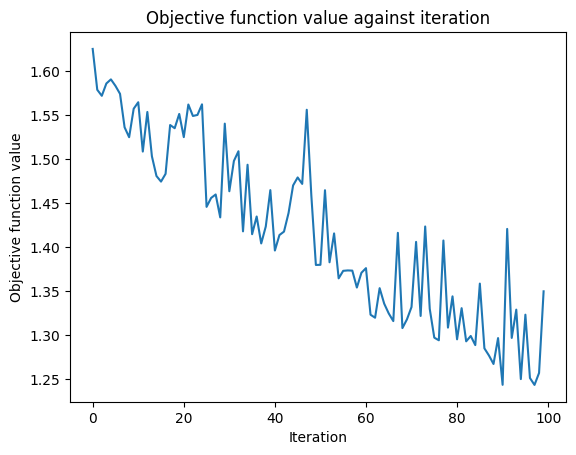

Precision:
 [0.8175925925925925, 0.8907828282828283, 0.8735042735042735, 0.7917228969860548, 0.9094794094794094, 0.7731718898385566, 0.7986704653371319, 0.8484848484848485, 0.8214285714285714, 0.7038027332144979]
Accuracy:
 [0.8055555555555556, 0.8611111111111112, 0.8611111111111112, 0.7777777777777778, 0.8888888888888888, 0.7777777777777778, 0.75, 0.8333333333333334, 0.75, 0.6944444444444444]
Recall:
 [0.8154761904761904, 0.8809523809523809, 0.8630952380952381, 0.7202380952380952, 0.9047619047619048, 0.7202380952380952, 0.7678571428571428, 0.8571428571428571, 0.7857142857142857, 0.6666666666666666]
F1:
 [0.8074548907882241, 0.8544452919738961, 0.8641975308641975, 0.7631874298540965, 0.8917878742440146, 0.7642153371320038, 0.7520128824476652, 0.8315789473684211, 0.75, 0.6921863799283154]
Time:
 [96.56821393966675, 96.4516954421997, 96.15842151641846, 95.75907683372498, 95.90370082855225, 96.34914994239807, 96.80658507347107, 96.62062525749207, 117.39056491851807, 122.12983393669128]


In [20]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 100
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=3, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

**Precision:**
 [0.8175925925925925, 0.8907828282828283, 0.8735042735042735, 0.7917228969860548, 0.9094794094794094, 0.7731718898385566, 0.7986704653371319, 0.8484848484848485, 0.8214285714285714, 0.7038027332144979]
**Mean Precision:**
0.8228640509148765±0.058

**Accuracy:**
 [0.8055555555555556, 0.8611111111111112, 0.8611111111111112, 0.7777777777777778, 0.8888888888888888, 0.7777777777777778, 0.75, 0.8333333333333334, 0.75, 0.6944444444444444]
**Mean Accuracy:**
0.8±0.058

**Recall:**
 [0.8154761904761904, 0.8809523809523809, 0.8630952380952381, 0.7202380952380952, 0.9047619047619048, 0.7202380952380952, 0.7678571428571428, 0.8571428571428571, 0.7857142857142857, 0.6666666666666666]
**Mean Recall:**
 0.7982142857142858±0.075

**F1:**
 [0.8074548907882241, 0.8544452919738961, 0.8641975308641975, 0.7631874298540965, 0.8917878742440146, 0.7642153371320038, 0.7520128824476652, 0.8315789473684211, 0.75, 0.6921863799283154]
**Mean F1:**
0.7971066564600834±0.06

**Time:**
 [96.56821393966675, 96.4516954421997, 96.15842151641846, 95.75907683372498, 95.90370082855225, 96.34914994239807, 96.80658507347107, 96.62062525749207, 117.39056491851807, 122.12983393669128]
**Mean Time:**
 101.01378676891326±9.43780103126481



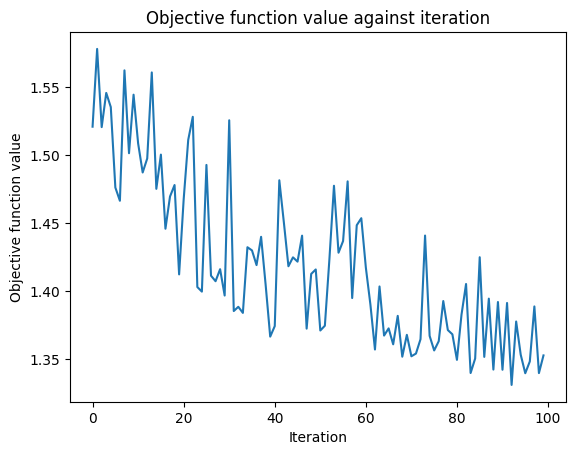

Precision:
 [0.6944444444444444, 0.766025641025641, 0.7210826210826211, 0.7569444444444444, 0.6919191919191919, 0.7885802469135803, 0.8016835016835017, 0.7763979665940449, 0.7751322751322751, 0.7899167109693426]
Accuracy:
 [0.6944444444444444, 0.6666666666666666, 0.7222222222222222, 0.6944444444444444, 0.6944444444444444, 0.6944444444444444, 0.7777777777777778, 0.75, 0.75, 0.7777777777777778]
Recall:
 [0.7023809523809524, 0.6607142857142857, 0.7261904761904763, 0.7202380952380952, 0.7023809523809524, 0.7202380952380952, 0.7559523809523809, 0.75, 0.7142857142857143, 0.7559523809523809]
F1:
 [0.6944444444444444, 0.6761904761904761, 0.7209450830140485, 0.6944444444444443, 0.687765006385696, 0.7085668276972625, 0.7832269050659855, 0.744844423666303, 0.7524074074074074, 0.7686964886964888]
Time:
 [142.35497736930847, 145.1288182735443, 140.86143016815186, 143.75081253051758, 147.48146152496338, 113.99957036972046, 113.74943017959595, 113.31708788871765, 113.72081542015076, 112.7892441749572

In [21]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 100
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=4, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

**Precision:**
 [0.6944444444444444, 0.766025641025641, 0.7210826210826211, 0.7569444444444444, 0.6919191919191919, 0.7885802469135803, 0.8016835016835017, 0.7763979665940449, 0.7751322751322751, 0.7899167109693426]
**Mean Precision:**
 0.7562127044209087±0.038

**Accuracy:**
 [0.6944444444444444, 0.6666666666666666, 0.7222222222222222, 0.6944444444444444, 0.6944444444444444, 0.6944444444444444, 0.7777777777777778, 0.75, 0.75, 0.7777777777777778]
**Mean Accuracy:**
 0.7222222222222222±0.037

**Recall:**
 [0.7023809523809524, 0.6607142857142857, 0.7261904761904763, 0.7202380952380952, 0.7023809523809524, 0.7202380952380952, 0.7559523809523809, 0.75, 0.7142857142857143, 0.7559523809523809]
**Mean Recall:**
0.7208333333333334±0.028

**F1:**
 [0.6944444444444444, 0.6761904761904761, 0.7209450830140485, 0.6944444444444443, 0.687765006385696, 0.7085668276972625, 0.7832269050659855, 0.744844423666303, 0.7524074074074074, 0.7686964886964888]
**Mean F1:**
0.7231531507012556±0.035

**Time:**
 [142.35497736930847, 145.1288182735443, 140.86143016815186, 143.75081253051758, 147.48146152496338, 113.99957036972046, 113.74943017959595, 113.31708788871765, 113.72081542015076, 112.78924417495728]
**Mean Time:**
128.71536478996276±15.288286465544141


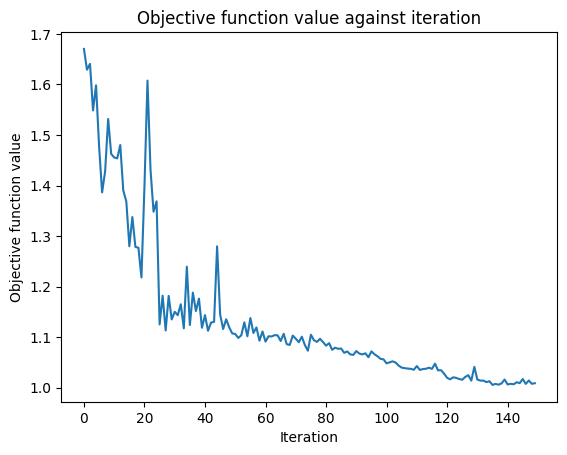

Precision:
 [0.9393939393939394, 0.9094794094794094, 0.9145299145299144, 0.8498316498316498, 0.896011396011396, 0.9145299145299144, 0.8892773892773893, 0.875, 0.8846153846153846, 0.8892773892773893]
Accuracy:
 [0.9166666666666666, 0.8888888888888888, 0.8611111111111112, 0.8333333333333334, 0.8611111111111112, 0.8611111111111112, 0.8611111111111112, 0.8333333333333334, 0.8333333333333334, 0.8611111111111112]
Recall:
 [0.9285714285714285, 0.9047619047619048, 0.8809523809523809, 0.8214285714285715, 0.8809523809523809, 0.8809523809523809, 0.8630952380952381, 0.8392857142857143, 0.8571428571428571, 0.8630952380952381]
F1:
 [0.9205944586061546, 0.8917878742440146, 0.8705087505087504, 0.8347381864623243, 0.8656790123456789, 0.8705087505087504, 0.8683960613785175, 0.8435897435897436, 0.8390652557319224, 0.8683960613785175]
Time:
 [90.3340094089508, 89.91742515563965, 89.99252820014954, 90.1663887500763, 90.43863296508789, 90.13065075874329, 90.56057071685791, 90.13167238235474, 90.221441507339

In [22]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 150
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=1, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

**Precision:**
 [0.9393939393939394, 0.9094794094794094, 0.9145299145299144, 0.8498316498316498, 0.896011396011396, 0.9145299145299144, 0.8892773892773893, 0.875, 0.8846153846153846, 0.8892773892773893]
**Mean Precision:**
0.8961946386946386±0.023

**Accuracy:**
 [0.9166666666666666, 0.8888888888888888, 0.8611111111111112, 0.8333333333333334, 0.8611111111111112, 0.8611111111111112, 0.8611111111111112, 0.8333333333333334, 0.8333333333333334, 0.8611111111111112]
**Mean Accuracy:**
0.861111111111111±0.025

**Recall:**
 [0.9285714285714285, 0.9047619047619048, 0.8809523809523809, 0.8214285714285715, 0.8809523809523809, 0.8809523809523809, 0.8630952380952381, 0.8392857142857143, 0.8571428571428571, 0.8630952380952381]
**Mean Recall:**
0.8720238095238095±0.029

**F1:**
 [0.9205944586061546, 0.8917878742440146, 0.8705087505087504, 0.8347381864623243, 0.8656790123456789, 0.8705087505087504, 0.8683960613785175, 0.8435897435897436, 0.8390652557319224, 0.8683960613785175]
**Mean F1:**
0.8673264154754374±0.024

**Time:**
 [90.3340094089508, 89.91742515563965, 89.99252820014954, 90.1663887500763, 90.43863296508789, 90.13065075874329, 90.56057071685791, 90.13167238235474, 90.22144150733948, 90.00642323493958]
**Mean Time:**
90.18997430801392±0.19373765764443432


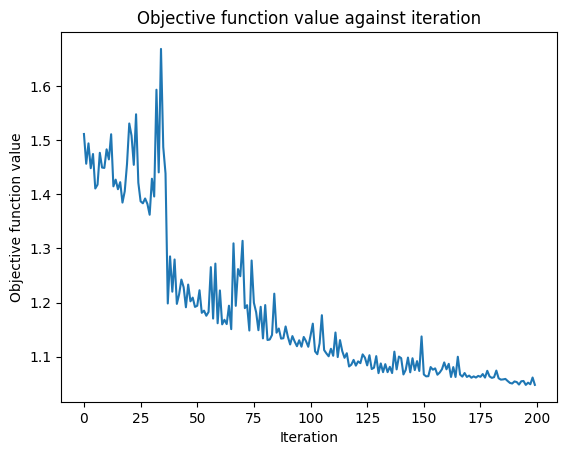

Precision:
 [0.8929249762583097, 0.925925925925926, 0.8635912698412699, 0.9555555555555555, 0.9163817663817664, 0.9047619047619047, 0.9203703703703704, 0.925925925925926, 0.9163817663817664, 0.9555555555555555]
Accuracy:
 [0.8888888888888888, 0.8888888888888888, 0.8611111111111112, 0.9444444444444444, 0.9166666666666666, 0.8333333333333334, 0.9166666666666666, 0.8888888888888888, 0.9166666666666666, 0.9444444444444444]
Recall:
 [0.8869047619047619, 0.9047619047619048, 0.8273809523809524, 0.9523809523809524, 0.9107142857142857, 0.8571428571428571, 0.9107142857142857, 0.9047619047619048, 0.9107142857142857, 0.9523809523809524]
F1:
 [0.8897966594045025, 0.8957264957264957, 0.859670781893004, 0.9465020576131687, 0.9156023839931886, 0.8446645946645945, 0.9175890449836811, 0.8957264957264957, 0.9156023839931886, 0.9465020576131687]
Time:
 [156.49138951301575, 155.3300166130066, 155.79430890083313, 155.23074793815613, 191.48892283439636, 200.82042741775513, 199.38114023208618, 199.00273489952

In [23]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 200
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=2, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

**Precision:**
 [0.8929249762583097, 0.925925925925926, 0.8635912698412699, 0.9555555555555555, 0.9163817663817664, 0.9047619047619047, 0.9203703703703704, 0.925925925925926, 0.9163817663817664, 0.9555555555555555]

**Mean Precision:**
0.9177375016958351±0.026

**Accuracy:**
 [0.8888888888888888, 0.8888888888888888, 0.8611111111111112, 0.9444444444444444, 0.9166666666666666, 0.8333333333333334, 0.9166666666666666, 0.8888888888888888, 0.9166666666666666, 0.9444444444444444]

**Mean Accuracy:**
0.9±0.033

**Recall:**
 [0.8869047619047619, 0.9047619047619048, 0.8273809523809524, 0.9523809523809524, 0.9107142857142857, 0.8571428571428571, 0.9107142857142857, 0.9047619047619048, 0.9107142857142857, 0.9523809523809524]

**Mean Recall:**
0.9017857142857142±0.036

**F1:**
 [0.8897966594045025, 0.8957264957264957, 0.859670781893004, 0.9465020576131687, 0.9156023839931886, 0.8446645946645945, 0.9175890449836811, 0.8957264957264957, 0.9156023839931886, 0.9465020576131687]

**Mean F1**
0.9027382955611488±0.031

**Time:**
 [156.49138951301575, 155.3300166130066, 155.79430890083313, 155.23074793815613, 191.48892283439636, 200.82042741775513, 199.38114023208618, 199.00273489952087, 201.45121335983276, 202.8497440814972]
 
**Mean Time:**
181.78406457901002±21.478707474433612



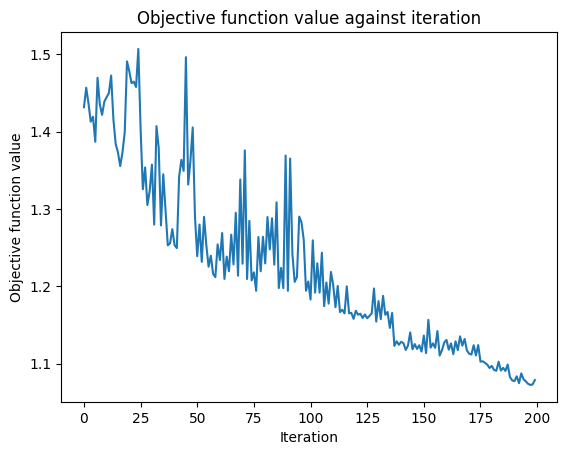

Precision:
 [0.8892773892773893, 0.9393939393939394, 0.8564814814814814, 0.8682336182336182, 0.8500000000000001, 0.9246913580246914, 0.9256410256410257, 0.9094794094794094, 0.71476453829395, 0.925925925925926]
Accuracy:
 [0.8611111111111112, 0.9166666666666666, 0.7777777777777778, 0.8611111111111112, 0.8333333333333334, 0.9166666666666666, 0.9166666666666666, 0.8888888888888888, 0.7222222222222222, 0.8888888888888888]
Recall:
 [0.8630952380952381, 0.9285714285714285, 0.7916666666666666, 0.8452380952380952, 0.8392857142857143, 0.9107142857142857, 0.9285714285714285, 0.9047619047619048, 0.6904761904761906, 0.9047619047619048]
F1:
 [0.8683960613785175, 0.9205944586061546, 0.7945480445480445, 0.8636528685548294, 0.8373694207027539, 0.9174598221251364, 0.9176954732510288, 0.8917878742440146, 0.7124082607953576, 0.8957264957264957]
Time:
 [249.6665449142456, 246.4471173286438, 244.6191051006317, 249.34004735946655, 252.51988863945007, 244.7626757621765, 195.51367473602295, 194.59669399261475

In [25]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 200
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=3, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

**Precision:**
 [0.8892773892773893, 0.9393939393939394, 0.8564814814814814, 0.8682336182336182, 0.8500000000000001, 0.9246913580246914, 0.9256410256410257, 0.9094794094794094, 0.71476453829395, 0.925925925925926]

**Mean Precision:**
0.8803888685751431±0.062

**Accuracy:**
 [0.8611111111111112, 0.9166666666666666, 0.7777777777777778, 0.8611111111111112, 0.8333333333333334, 0.9166666666666666, 0.9166666666666666, 0.8888888888888888, 0.7222222222222222, 0.8888888888888888]

**Mean Accuracy:**
0.8583333333333332±0.061

**Recall:**
 [0.8630952380952381, 0.9285714285714285, 0.7916666666666666, 0.8452380952380952, 0.8392857142857143, 0.9107142857142857, 0.9285714285714285, 0.9047619047619048, 0.6904761904761906, 0.9047619047619048]

**Mean Recall:**
0.8607142857142855±0.07

**F1:**
 [0.8683960613785175, 0.9205944586061546, 0.7945480445480445, 0.8636528685548294, 0.8373694207027539, 0.9174598221251364, 0.9176954732510288, 0.8917878742440146, 0.7124082607953576, 0.8957264957264957]

**Mean F1:**
0.8619638779932334±0.06

**Time:**
 [249.6665449142456, 246.4471173286438, 244.6191051006317, 249.34004735946655, 252.51988863945007, 244.7626757621765, 195.51367473602295, 194.59669399261475, 194.86786794662476, 195.14848279953003]
 
**Mean Time:**
226.74820985794068±25.9922537923594



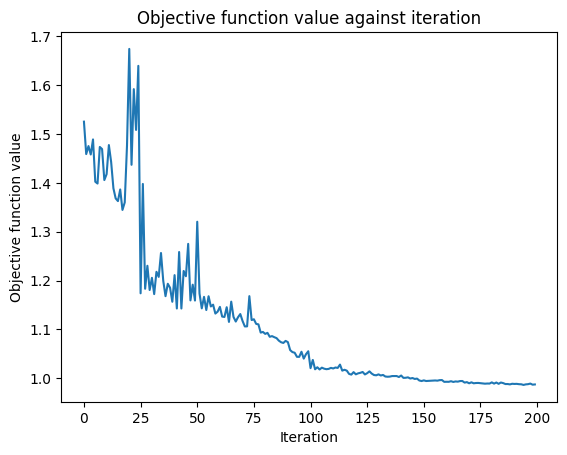

Precision:
 [0.9034188034188033, 0.9176163342830009, 0.925925925925926, 0.8892773892773893, 0.925925925925926, 0.9228395061728395, 0.8929249762583097, 0.9555555555555555, 0.9145299145299144, 0.9047619047619047]
Accuracy:
 [0.8888888888888888, 0.9166666666666666, 0.8888888888888888, 0.8611111111111112, 0.8888888888888888, 0.9166666666666666, 0.8888888888888888, 0.9444444444444444, 0.8611111111111112, 0.8333333333333334]
Recall:
 [0.8869047619047619, 0.9285714285714285, 0.9047619047619048, 0.8630952380952381, 0.9047619047619048, 0.9107142857142857, 0.8869047619047619, 0.9523809523809524, 0.8809523809523809, 0.8571428571428571]
F1:
 [0.8930041152263376, 0.9159404502541757, 0.8957264957264957, 0.8683960613785175, 0.8944855967078189, 0.9186032437666424, 0.8897966594045025, 0.9465020576131687, 0.8705087505087504, 0.8460606060606062]
Time:
 [121.55064988136292, 122.79406714439392, 122.11337304115295, 122.25503087043762, 123.30447506904602, 123.73043942451477, 122.57032346725464, 122.549010753

In [26]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 200
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=1, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

**Precision:**
 [0.9034188034188033, 0.9176163342830009, 0.925925925925926, 0.8892773892773893, 0.925925925925926, 0.9228395061728395, 0.8929249762583097, 0.9555555555555555, 0.9145299145299144, 0.9047619047619047]

**Mean Precision:**
0.915277623610957±0.018

**Accuracy:**
 [0.8888888888888888, 0.9166666666666666, 0.8888888888888888, 0.8611111111111112, 0.8888888888888888, 0.9166666666666666, 0.8888888888888888, 0.9444444444444444, 0.8611111111111112, 0.8333333333333334]

**Mean Accuracy:**
0.888888888888889±0.03

**Recall:**
 [0.8869047619047619, 0.9285714285714285, 0.9047619047619048, 0.8630952380952381, 0.9047619047619048, 0.9107142857142857, 0.8869047619047619, 0.9523809523809524, 0.8809523809523809, 0.8571428571428571]

**Mean Recall:**
0.8976190476190476±0.0275

**F1:**
 [0.8930041152263376, 0.9159404502541757, 0.8957264957264957, 0.8683960613785175, 0.8944855967078189, 0.9186032437666424, 0.8897966594045025, 0.9465020576131687, 0.8705087505087504, 0.8460606060606062]

**Mean F1:**
 0.8939024036647016±0.027
 
**Time:**
 [121.55064988136292, 122.79406714439392, 122.11337304115295, 122.25503087043762, 123.30447506904602, 123.73043942451477, 122.57032346725464, 122.54901075363159, 122.69259524345398, 123.02915096282959]
 
**Mean Time:**
122.6589115858078±0.5856880500124855


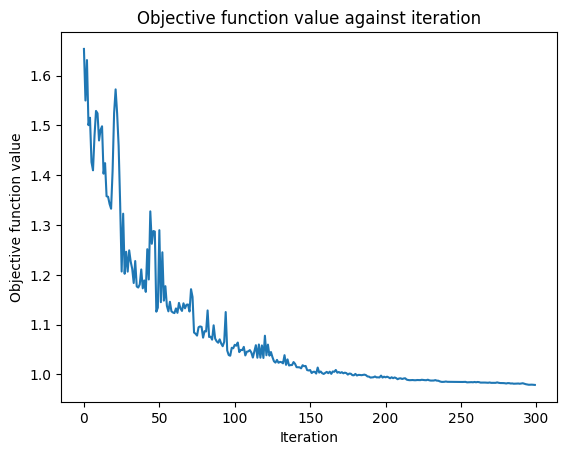

Precision:
 [0.9393939393939394, 0.9393939393939394, 0.9393939393939394, 0.9393939393939394, 0.9145299145299144, 0.925925925925926, 0.9166666666666666, 0.925925925925926, 0.925925925925926, 0.9034188034188033]
Accuracy:
 [0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.8611111111111112, 0.8888888888888888, 0.9166666666666666, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888]
Recall:
 [0.9285714285714285, 0.9285714285714285, 0.9285714285714285, 0.9285714285714285, 0.8809523809523809, 0.9047619047619048, 0.9107142857142857, 0.9047619047619048, 0.9047619047619048, 0.8869047619047619]
F1:
 [0.9205944586061546, 0.9205944586061546, 0.9205944586061546, 0.9205944586061546, 0.8705087505087504, 0.8944855967078189, 0.9166666666666666, 0.8944855967078189, 0.8944855967078189, 0.8930041152263376]
Time:
 [183.14595007896423, 182.80808973312378, 183.73312878608704, 211.62290358543396, 231.75868821144104, 236.88856625556946, 236.1688630580902, 210.71531009674

In [28]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 300
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=1, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

**Precision:**
 [0.9393939393939394, 0.9393939393939394, 0.9393939393939394, 0.9393939393939394, 0.9145299145299144, 0.925925925925926, 0.9166666666666666, 0.925925925925926, 0.925925925925926, 0.9034188034188033]

**Mean Precision:**
0.9269968919968921±0.012

**Accuracy:**
 [0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.8611111111111112, 0.8888888888888888, 0.9166666666666666, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888]

**Mean Accuracy:**
0.9±0.018

**Recall:**
 [0.9285714285714285, 0.9285714285714285, 0.9285714285714285, 0.9285714285714285, 0.8809523809523809, 0.9047619047619048, 0.9107142857142857, 0.9047619047619048, 0.9047619047619048, 0.8869047619047619]

**Mean Recall:**
0.9107142857142858±0.017

**F1:**
 [0.9205944586061546, 0.9205944586061546, 0.9205944586061546, 0.9205944586061546, 0.8705087505087504, 0.8944855967078189, 0.9166666666666666, 0.8944855967078189, 0.8944855967078189, 0.8930041152263376]

**Mean F1:**
0.9046014156949831±0.017

**Time:**
 [183.14595007896423, 182.80808973312378, 183.73312878608704, 211.62290358543396, 231.75868821144104, 236.88856625556946, 236.1688630580902, 210.71531009674072, 183.46513152122498, 182.97371983528137]
 
**Mean Time:**
204.32803511619568±22.688512730204067


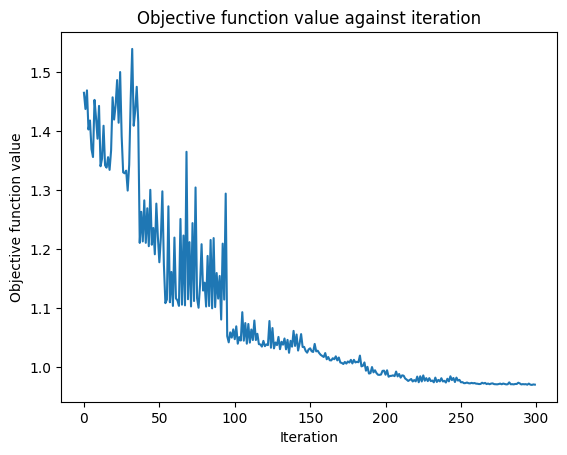

Precision:
 [0.9094794094794094, 0.9166666666666666, 0.7991452991452992, 0.9555555555555555, 0.896011396011396, 0.9009259259259258, 0.925925925925926, 0.9228395061728395, 0.9094794094794094, 0.9555555555555555]
Accuracy:
 [0.8888888888888888, 0.9166666666666666, 0.7777777777777778, 0.9444444444444444, 0.8611111111111112, 0.8888888888888888, 0.8888888888888888, 0.9166666666666666, 0.8888888888888888, 0.9444444444444444]
Recall:
 [0.9047619047619048, 0.9107142857142857, 0.7559523809523809, 0.9523809523809524, 0.8809523809523809, 0.8869047619047619, 0.9047619047619048, 0.9107142857142857, 0.9047619047619048, 0.9523809523809524]
F1:
 [0.8917878742440146, 0.9166666666666666, 0.786008230452675, 0.9465020576131687, 0.8656790123456789, 0.8907882241215574, 0.8957264957264957, 0.9186032437666424, 0.8917878742440146, 0.9465020576131687]
Time:
 [234.9155411720276, 236.34190893173218, 234.95381784439087, 235.53967380523682, 236.25861978530884, 237.01499915122986, 236.06364154815674, 267.45973324775

In [29]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 300
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=2, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

**Precision:**
 [0.9094794094794094, 0.9166666666666666, 0.7991452991452992, 0.9555555555555555, 0.896011396011396, 0.9009259259259258, 0.925925925925926, 0.9228395061728395, 0.9094794094794094, 0.9555555555555555]

**Mean Precision:**
0.9091584649917983±0.041

**Accuracy:**
 [0.8888888888888888, 0.9166666666666666, 0.7777777777777778, 0.9444444444444444, 0.8611111111111112, 0.8888888888888888, 0.8888888888888888, 0.9166666666666666, 0.8888888888888888, 0.9444444444444444]

**Mean Accuracy:**
0.8916666666666666±0.046

**Recall:**
 [0.9047619047619048, 0.9107142857142857, 0.7559523809523809, 0.9523809523809524, 0.8809523809523809, 0.8869047619047619, 0.9047619047619048, 0.9107142857142857, 0.9047619047619048, 0.9523809523809524]

**Mean Recall:**
0.8964285714285714±0.052

**F1:**
 [0.8917878742440146, 0.9166666666666666, 0.786008230452675, 0.9465020576131687, 0.8656790123456789, 0.8907882241215574, 0.8957264957264957, 0.9186032437666424, 0.8917878742440146, 0.9465020576131687]

**Mean F1:**
0.8950051736794082±0.044

**Time:**
 [234.9155411720276, 236.34190893173218, 234.95381784439087, 235.53967380523682, 236.25861978530884, 237.01499915122986, 236.06364154815674, 267.45973324775696, 302.3043158054352, 300.0834147930145]
 
**Mean Time:**
252.09356660842894±26.279902602318625


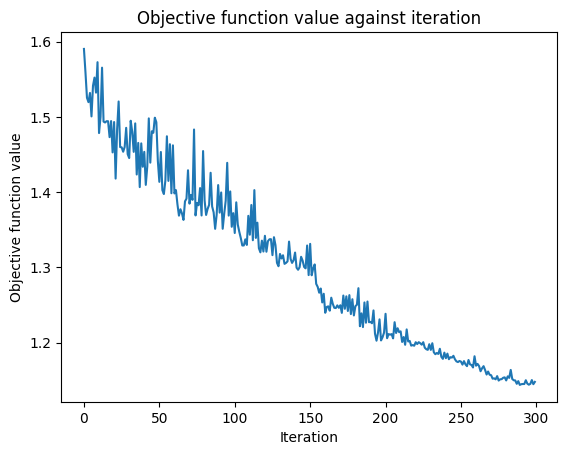

Precision:
 [0.9393939393939394, 0.9555555555555555, 0.925925925925926, 0.9055555555555556, 0.9116161616161617, 0.8914141414141414, 0.974074074074074, 0.9236111111111112, 0.8847222222222223, 0.8244625744625744]
Accuracy:
 [0.9166666666666666, 0.9444444444444444, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8611111111111112, 0.9722222222222222, 0.9166666666666666, 0.8611111111111112, 0.8055555555555556]
Recall:
 [0.9285714285714285, 0.9523809523809524, 0.9047619047619048, 0.8869047619047619, 0.9047619047619048, 0.8630952380952381, 0.9761904761904763, 0.9107142857142857, 0.8630952380952381, 0.8154761904761904]
F1:
 [0.9205944586061546, 0.9465020576131687, 0.8944855967078189, 0.8929249762583095, 0.89046783625731, 0.8670760233918129, 0.9721867461331064, 0.9163817663817664, 0.8598765432098765, 0.8085670015494577]
Time:
 [341.1889729499817, 328.0985631942749, 369.09259366989136, 371.76506638526917, 372.44227623939514, 365.26895356178284, 299.3195288181305, 291.88140630722046

In [30]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 300
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=3, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

**Precision:**
 [0.9393939393939394, 0.9555555555555555, 0.925925925925926, 0.9055555555555556, 0.9116161616161617, 0.8914141414141414, 0.974074074074074, 0.9236111111111112, 0.8847222222222223, 0.8244625744625744]

**Mean Precision:**
0.9136331261331261±0.04

**Accuracy:**
 [0.9166666666666666, 0.9444444444444444, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8611111111111112, 0.9722222222222222, 0.9166666666666666, 0.8611111111111112, 0.8055555555555556]

**Mean Accuracy:**
0.8944444444444445±0.044

**Recall:**
 [0.9285714285714285, 0.9523809523809524, 0.9047619047619048, 0.8869047619047619, 0.9047619047619048, 0.8630952380952381, 0.9761904761904763, 0.9107142857142857, 0.8630952380952381, 0.8154761904761904]

**Mean Recall:**
0.900595238095238±0.044

**F1:**
 [0.9205944586061546, 0.9465020576131687, 0.8944855967078189, 0.8929249762583095, 0.89046783625731, 0.8670760233918129, 0.9721867461331064, 0.9163817663817664, 0.8598765432098765, 0.8085670015494577]

**Mean F1:**
 0.8969063006108782±0.044

**Time:**
 [341.1889729499817, 328.0985631942749, 369.09259366989136, 371.76506638526917, 372.44227623939514, 365.26895356178284, 299.3195288181305, 291.88140630722046, 292.1728472709656, 292.1734161376953]
 
**Mean Time:**
332.34036245346067±34.12901344681647


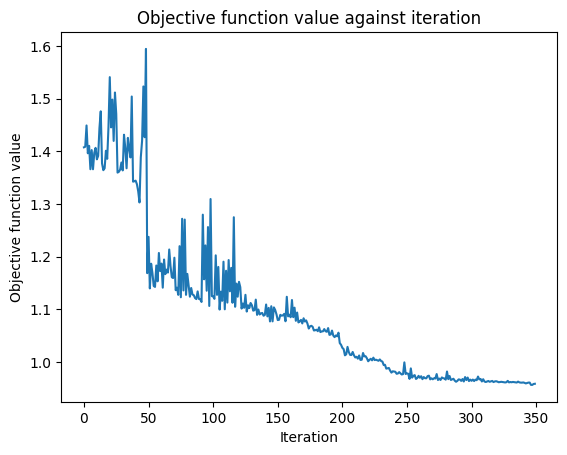

Precision:
 [0.9753086419753088, 0.9145299145299144, 0.9228395061728395, 0.925925925925926, 0.9047619047619047, 0.9034188034188033, 0.9236111111111112, 0.8592592592592593, 0.925925925925926, 0.9393939393939394]
Accuracy:
 [0.9722222222222222, 0.8611111111111112, 0.9166666666666666, 0.8888888888888888, 0.8333333333333334, 0.8888888888888888, 0.9166666666666666, 0.8333333333333334, 0.8888888888888888, 0.9166666666666666]
Recall:
 [0.9761904761904763, 0.8809523809523809, 0.9107142857142857, 0.9047619047619048, 0.8571428571428571, 0.8869047619047619, 0.8928571428571429, 0.8214285714285715, 0.9047619047619048, 0.9285714285714285]
F1:
 [0.9725248123940935, 0.8678718400940624, 0.9186032437666424, 0.8944855967078189, 0.8460606060606062, 0.8930041152263376, 0.9145502645502646, 0.839029374201788, 0.8944855967078189, 0.9182456140350878]
Time:
 [343.91902565956116, 441.6792607307434, 437.2064847946167, 427.67659759521484, 342.0132865905762, 340.8148512840271, 341.67409014701843, 340.7586371898651,

In [31]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 350
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=3, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

**Precision:**
 [0.9753086419753088, 0.9145299145299144, 0.9228395061728395, 0.925925925925926, 0.9047619047619047, 0.9034188034188033, 0.9236111111111112, 0.8592592592592593, 0.925925925925926, 0.9393939393939394]

**Mean Precision:**
0.9194974932474931±0.028

**Accuracy:**
 [0.9722222222222222, 0.8611111111111112, 0.9166666666666666, 0.8888888888888888, 0.8333333333333334, 0.8888888888888888, 0.9166666666666666, 0.8333333333333334, 0.8888888888888888, 0.9166666666666666]

**Mean Accuracy:**
0.8916666666666666±0.04

**Recall:**
 [0.9761904761904763, 0.8809523809523809, 0.9107142857142857, 0.9047619047619048, 0.8571428571428571, 0.8869047619047619, 0.8928571428571429, 0.8214285714285715, 0.9047619047619048, 0.9285714285714285]

**Mean Recall:**
0.8964285714285716±0.039

**F1:**
 [0.9725248123940935, 0.8678718400940624, 0.9186032437666424, 0.8944855967078189, 0.8460606060606062, 0.8930041152263376, 0.9145502645502646, 0.839029374201788, 0.8944855967078189, 0.9182456140350878]

**Mean F1:**
0.8958861063744521±0.037

**Time:**
 [343.91902565956116, 441.6792607307434, 437.2064847946167, 427.67659759521484, 342.0132865905762, 340.8148512840271, 341.67409014701843, 340.7586371898651, 378.65614581108093, 454.22248673439026]
 
**Mean Time:**
384.8620866537094±46.81177051350796


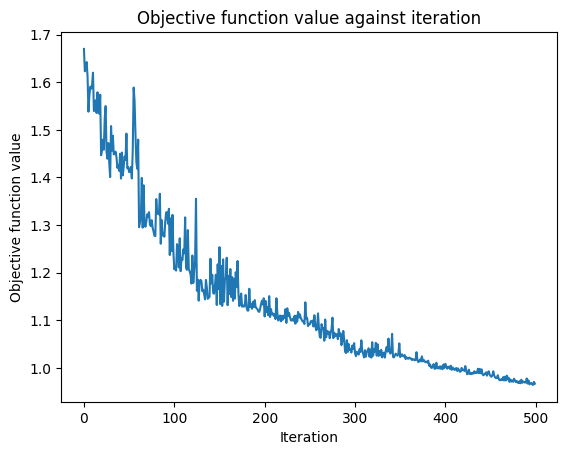

Precision:
 [0.9753086419753088, 0.8867845117845117, 0.9393939393939394, 0.925925925925926, 0.7882716049382715, 0.9393939393939394, 0.8953373015873015, 0.9393939393939394, 0.9277777777777777, 0.9753086419753088]
Accuracy:
 [0.9722222222222222, 0.8611111111111112, 0.9166666666666666, 0.8888888888888888, 0.7222222222222222, 0.9166666666666666, 0.8888888888888888, 0.9166666666666666, 0.9166666666666666, 0.9722222222222222]
Recall:
 [0.9761904761904763, 0.8630952380952381, 0.9285714285714285, 0.9047619047619048, 0.7619047619047619, 0.9285714285714285, 0.8690476190476191, 0.9285714285714285, 0.9285714285714285, 0.9761904761904763]
F1:
 [0.9725248123940935, 0.8672881158261275, 0.9205944586061546, 0.8957264957264957, 0.724266072092159, 0.9205944586061546, 0.8893004115226337, 0.9205944586061546, 0.9176163342830009, 0.9725248123940935]
Time:
 [684.6943068504333, 596.5562462806702, 586.8606774806976, 568.1896049976349, 570.4605326652527, 611.3181092739105, 665.363055229187, 600.3840615749359, 59

In [6]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 500
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=4, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")
#   0.9065476190476189±0.05988284575251499

# **EfficientSU2+Hadamard/TwoLocal**

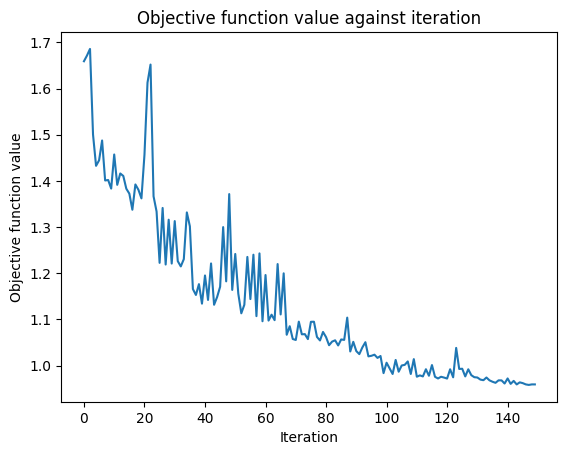

Precision:
 [0.947530864197531, 0.9444444444444444, 0.9277777777777777, 0.7929292929292928, 0.947530864197531, 0.7603485838779956, 0.8898385565052231, 0.9207027540360875, 0.947530864197531, 0.9176163342830009]
Accuracy:
 [0.9444444444444444, 0.9444444444444444, 0.9166666666666666, 0.7777777777777778, 0.9444444444444444, 0.7222222222222222, 0.8888888888888888, 0.9166666666666666, 0.9444444444444444, 0.9166666666666666]
Recall:
 [0.9523809523809524, 0.9523809523809524, 0.9285714285714285, 0.7916666666666666, 0.9523809523809524, 0.7440476190476191, 0.9047619047619048, 0.9107142857142857, 0.9523809523809524, 0.9285714285714285]
F1:
 [0.9447470346163157, 0.9444444444444444, 0.9176163342830009, 0.7770760233918129, 0.9447470346163157, 0.7039426523297492, 0.888162672476398, 0.9175744371822803, 0.9447470346163157, 0.9159404502541757]
Time:
 [123.21550250053406, 129.78526782989502, 128.23483085632324, 126.32370901107788, 129.77939701080322, 126.15370774269104, 128.3030288219452, 130.215711832046

In [13]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 150
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)
    
  qc_init = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
    qc_init.h(i)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x'
                           ,initial_state=qc_init)
  ansatz = TwoLocal(num_qubits=num_qubits, reps=1, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
  
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.947530864197531, 0.9444444444444444, 0.9277777777777777, 0.7929292929292928, 0.947530864197531, 0.7603485838779956, 0.8898385565052231, 0.9207027540360875, 0.947530864197531, 0.9176163342830009]
Accuracy:
 [0.9444444444444444, 0.9444444444444444, 0.9166666666666666, 0.7777777777777778, 0.9444444444444444, 0.7222222222222222, 0.8888888888888888, 0.9166666666666666, 0.9444444444444444, 0.9166666666666666]
Recall:
 [0.9523809523809524, 0.9523809523809524, 0.9285714285714285, 0.7916666666666666, 0.9523809523809524, 0.7440476190476191, 0.9047619047619048, 0.9107142857142857, 0.9523809523809524, 0.9285714285714285]
F1:
 [0.9447470346163157, 0.9444444444444444, 0.9176163342830009, 0.7770760233918129, 0.9447470346163157, 0.7039426523297492, 0.888162672476398, 0.9175744371822803, 0.9447470346163157, 0.9159404502541757]
Time:
 [123.21550250053406, 129.78526782989502, 128.23483085632324, 126.32370901107788, 129.77939701080322, 126.15370774269104, 128.3030288219452, 130.2157118320465, 127.51935315132141, 129.93356275558472]
 
Mean Precision: 0.8996250336446415±0.06428989443630462
Mean Accuracy: 0.8916666666666666±0.07396403864274637
Mean Recall: 0.9017857142857142±0.06983591474780103
Mean F1: 0.8898998118210809±0.07843740555631334
Mean Time: 127.94640715122223±2.108575660417705


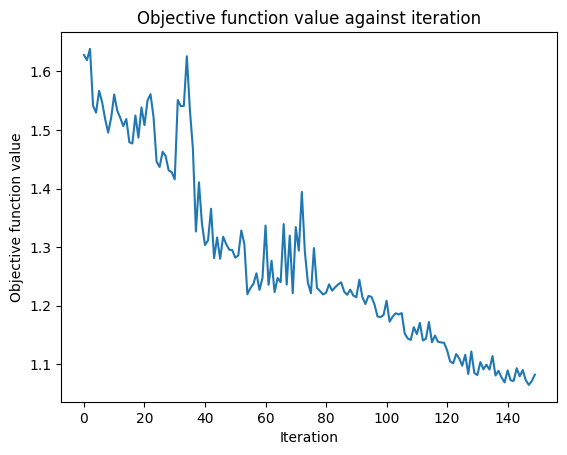

Precision:
 [0.8348117024587612, 0.9236111111111112, 0.9236111111111112, 0.6994047619047619, 0.8382716049382716, 0.7885521885521886, 0.8691358024691359, 0.8634259259259259, 0.7885521885521886, 0.8598137973137974]
Accuracy:
 [0.8333333333333334, 0.9166666666666666, 0.9166666666666666, 0.6666666666666666, 0.8055555555555556, 0.7777777777777778, 0.8333333333333334, 0.8611111111111112, 0.7777777777777778, 0.8611111111111112]
Recall:
 [0.8214285714285715, 0.8928571428571429, 0.8928571428571429, 0.6785714285714285, 0.8154761904761904, 0.7738095238095238, 0.8571428571428571, 0.8452380952380952, 0.7738095238095238, 0.8452380952380952]
F1:
 [0.8281775572098152, 0.9145502645502646, 0.9145502645502646, 0.6590909090909091, 0.8015658837248043, 0.7768071519795658, 0.8206369248035915, 0.8586894586894587, 0.7768071519795658, 0.8576131687242798]
Time:
 [158.24889469146729, 163.21503329277039, 164.24885725975037, 160.59579920768738, 160.64016151428223, 150.30864024162292, 124.57698559761047, 124.6855385

In [14]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 150
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)
    
  qc_init = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
    qc_init.h(i)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x'
                           ,initial_state=qc_init)
  ansatz = TwoLocal(num_qubits=num_qubits, reps=2, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
  
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.8348117024587612, 0.9236111111111112, 0.9236111111111112, 0.6994047619047619, 0.8382716049382716, 0.7885521885521886, 0.8691358024691359, 0.8634259259259259, 0.7885521885521886, 0.8598137973137974]
Accuracy:
 [0.8333333333333334, 0.9166666666666666, 0.9166666666666666, 0.6666666666666666, 0.8055555555555556, 0.7777777777777778, 0.8333333333333334, 0.8611111111111112, 0.7777777777777778, 0.8611111111111112]
Recall:
 [0.8214285714285715, 0.8928571428571429, 0.8928571428571429, 0.6785714285714285, 0.8154761904761904, 0.7738095238095238, 0.8571428571428571, 0.8452380952380952, 0.7738095238095238, 0.8452380952380952]
F1:
 [0.8281775572098152, 0.9145502645502646, 0.9145502645502646, 0.6590909090909091, 0.8015658837248043, 0.7768071519795658, 0.8206369248035915, 0.8586894586894587, 0.7768071519795658, 0.8576131687242798]
Time:
 [158.24889469146729, 163.21503329277039, 164.24885725975037, 160.59579920768738, 160.64016151428223, 150.30864024162292, 124.57698559761047, 124.68553853034973, 124.32200574874878, 124.54701137542725]
 
Mean Precision: 0.8389190194337253±0.06391469903635931
Mean Accuracy: 0.825±0.07032771611762313
Mean Recall: 0.8196428571428571±0.061286403407529055
Mean F1: 0.820848873530252±0.07128393816345045
Mean Time: 145.53889274597168±17.51182862707396


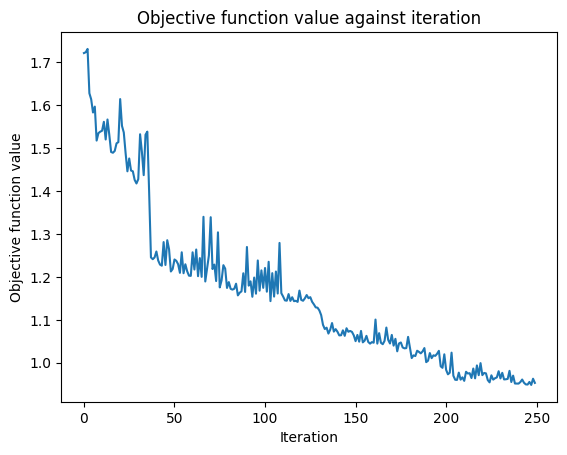

Precision:
 [0.8330687830687831, 0.9555555555555555, 0.8630104463437797, 0.9256410256410257, 0.9462962962962962, 0.9753086419753088, 0.9493827160493827, 0.8922839506172839, 0.9462962962962962, 0.947530864197531]
Accuracy:
 [0.8333333333333334, 0.9444444444444444, 0.8611111111111112, 0.9166666666666666, 0.9444444444444444, 0.9722222222222222, 0.9444444444444444, 0.8888888888888888, 0.9444444444444444, 0.9444444444444444]
Recall:
 [0.8214285714285715, 0.9523809523809524, 0.8630952380952381, 0.9285714285714285, 0.9345238095238096, 0.9761904761904763, 0.9523809523809524, 0.8869047619047619, 0.9345238095238096, 0.9523809523809524]
F1:
 [0.831992337164751, 0.9465020576131687, 0.8609900750423626, 0.9176954732510288, 0.9439974457215836, 0.9725248123940935, 0.9436036129748098, 0.8875452922106066, 0.9439974457215836, 0.9447470346163157]
Time:
 [260.8236196041107, 266.1265766620636, 269.0379741191864, 237.83068323135376, 274.5266718864441, 271.80985021591187, 251.52509379386902, 234.6498901844024

In [15]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 250
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)
    
  qc_init = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
    qc_init.h(i)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x'
                           ,initial_state=qc_init)
  ansatz = TwoLocal(num_qubits=num_qubits, reps=2, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
  
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.8330687830687831, 0.9555555555555555, 0.8630104463437797, 0.9256410256410257, 0.9462962962962962, 0.9753086419753088, 0.9493827160493827, 0.8922839506172839, 0.9462962962962962, 0.947530864197531]
Accuracy:
 [0.8333333333333334, 0.9444444444444444, 0.8611111111111112, 0.9166666666666666, 0.9444444444444444, 0.9722222222222222, 0.9444444444444444, 0.8888888888888888, 0.9444444444444444, 0.9444444444444444]
Recall:
 [0.8214285714285715, 0.9523809523809524, 0.8630952380952381, 0.9285714285714285, 0.9345238095238096, 0.9761904761904763, 0.9523809523809524, 0.8869047619047619, 0.9345238095238096, 0.9523809523809524]
F1:
 [0.831992337164751, 0.9465020576131687, 0.8609900750423626, 0.9176954732510288, 0.9439974457215836, 0.9725248123940935, 0.9436036129748098, 0.8875452922106066, 0.9439974457215836, 0.9447470346163157]
Time:
 [260.8236196041107, 266.1265766620636, 269.0379741191864, 237.83068323135376, 274.5266718864441, 271.80985021591187, 251.52509379386902, 234.64989018440247, 227.89673495292664, 214.16084814071655]
 
Mean Precision: 0.9234374576041244±0.04337535176879571
Mean Accuracy: 0.9194444444444445±0.04203540541783764
Mean Recall: 0.9202380952380954±0.045659068835155026
Mean F1: 0.9193595586710306±0.04250241552706723
Mean Time: 250.83879427909852±19.922089000289706


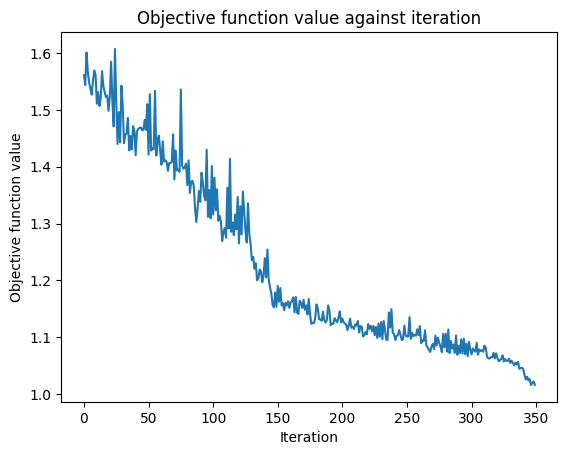

Precision:
 [0.9493827160493827, 0.925925925925926, 0.9145502645502646, 0.8670384399551065, 0.8683501683501683, 0.824074074074074, 0.9176163342830009, 0.9493827160493827, 0.8630104463437797, 0.8339506172839506]
Accuracy:
 [0.9444444444444444, 0.8888888888888888, 0.9166666666666666, 0.8611111111111112, 0.8611111111111112, 0.8055555555555556, 0.9166666666666666, 0.9444444444444444, 0.8611111111111112, 0.8333333333333334]
Recall:
 [0.9523809523809524, 0.9047619047619048, 0.8928571428571429, 0.8809523809523809, 0.8809523809523809, 0.8333333333333334, 0.9285714285714285, 0.9523809523809524, 0.8630952380952381, 0.8392857142857143]
F1:
 [0.9436036129748098, 0.8907407407407406, 0.914367816091954, 0.8572984749455339, 0.8573009791400596, 0.7956539499857915, 0.9159404502541757, 0.9436036129748098, 0.8609900750423626, 0.8308108389244293]
Time:
 [356.45901107788086, 356.3029730319977, 356.482542514801, 445.8015375137329, 440.69279646873474, 475.951064825058, 472.3660635948181, 392.77317070961, 510.

In [16]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 350
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)
    
  qc_init = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
    qc_init.h(i)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x'
                           ,initial_state=qc_init)
  ansatz = TwoLocal(num_qubits=num_qubits, reps=3, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
  
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.9493827160493827, 0.925925925925926, 0.9145502645502646, 0.8670384399551065, 0.8683501683501683, 0.824074074074074, 0.9176163342830009, 0.9493827160493827, 0.8630104463437797, 0.8339506172839506]
Accuracy:
 [0.9444444444444444, 0.8888888888888888, 0.9166666666666666, 0.8611111111111112, 0.8611111111111112, 0.8055555555555556, 0.9166666666666666, 0.9444444444444444, 0.8611111111111112, 0.8333333333333334]
Recall:
 [0.9523809523809524, 0.9047619047619048, 0.8928571428571429, 0.8809523809523809, 0.8809523809523809, 0.8333333333333334, 0.9285714285714285, 0.9523809523809524, 0.8630952380952381, 0.8392857142857143]
F1:
 [0.9436036129748098, 0.8907407407407406, 0.914367816091954, 0.8572984749455339, 0.8573009791400596, 0.7956539499857915, 0.9159404502541757, 0.9436036129748098, 0.8609900750423626, 0.8308108389244293]
Time:
 [356.45901107788086, 356.3029730319977, 356.482542514801, 445.8015375137329, 440.69279646873474, 475.951064825058, 472.3660635948181, 392.77317070961, 510.92702984809875, 491.3834593296051]
 
Mean Precision: 0.8913281702865035±0.043477774320704876
Mean Accuracy: 0.8833333333333334±0.04444444444444442
Mean Recall: 0.8928571428571429±0.0401068583998167
Mean F1: 0.8810310551074668±0.046469609891440736
Mean Time: 429.9139648914337±56.76057576854857


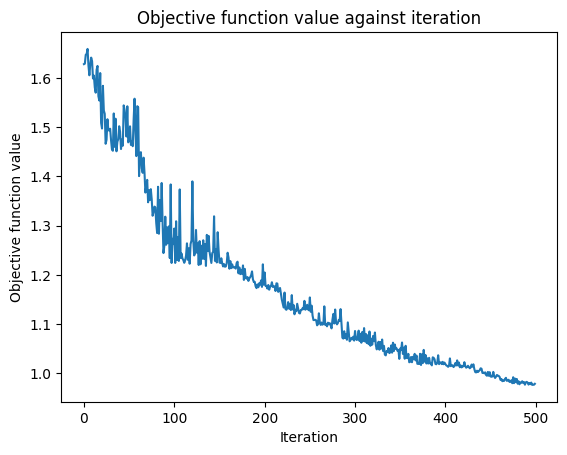

Precision:
 [0.9176163342830009, 0.9134680134680134, 0.9256410256410257, 0.8663580246913579, 0.974074074074074, 0.8910493827160493, 0.9493827160493827, 1.0, 0.9493827160493827, 0.9513888888888888]
Accuracy:
 [0.9166666666666666, 0.8888888888888888, 0.9166666666666666, 0.8611111111111112, 0.9722222222222222, 0.8888888888888888, 0.9444444444444444, 1.0, 0.9444444444444444, 0.9444444444444444]
Recall:
 [0.9285714285714285, 0.9047619047619048, 0.9285714285714285, 0.8630952380952381, 0.9761904761904763, 0.9047619047619048, 0.9523809523809524, 1.0, 0.9523809523809524, 0.9523809523809524]
F1:
 [0.9159404502541757, 0.8866875042011159, 0.9176954732510288, 0.8607253688389592, 0.9721867461331064, 0.8868691596886323, 0.9436036129748098, 1.0, 0.9436036129748098, 0.9441595441595442]
Time:
 [878.1305494308472, 879.4321615695953, 855.2608759403229, 856.7435941696167, 946.7726550102234, 947.312028169632, 1029.7185146808624, 897.1140203475952, 1013.1820526123047, 902.52090716362]
Mean Precision: 0.93383

In [17]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 500
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)
    
  qc_init = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
    qc_init.h(i)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x'
                           ,initial_state=qc_init)
  ansatz = TwoLocal(num_qubits=num_qubits, reps=4, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
  
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.9176163342830009, 0.9134680134680134, 0.9256410256410257, 0.8663580246913579, 0.974074074074074, 0.8910493827160493, 0.9493827160493827, 1.0, 0.9493827160493827, 0.9513888888888888]
Accuracy:
 [0.9166666666666666, 0.8888888888888888, 0.9166666666666666, 0.8611111111111112, 0.9722222222222222, 0.8888888888888888, 0.9444444444444444, 1.0, 0.9444444444444444, 0.9444444444444444]
Recall:
 [0.9285714285714285, 0.9047619047619048, 0.9285714285714285, 0.8630952380952381, 0.9761904761904763, 0.9047619047619048, 0.9523809523809524, 1.0, 0.9523809523809524, 0.9523809523809524]
F1:
 [0.9159404502541757, 0.8866875042011159, 0.9176954732510288, 0.8607253688389592, 0.9721867461331064, 0.8868691596886323, 0.9436036129748098, 1.0, 0.9436036129748098, 0.9441595441595442]
Time:
 [878.1305494308472, 879.4321615695953, 855.2608759403229, 856.7435941696167, 946.7726550102234, 947.312028169632, 1029.7185146808624, 897.1140203475952, 1013.1820526123047, 902.52090716362]
 
Mean Precision: 0.9338361175861177±0.0373059565963372
Mean Accuracy: 0.9277777777777777±0.03967460238079361
Mean Recall: 0.9363095238095239±0.03727255286774589
Mean F1: 0.9271471472476183±0.040066484300643475
Mean Time: 920.618735909462±58.822236620260554


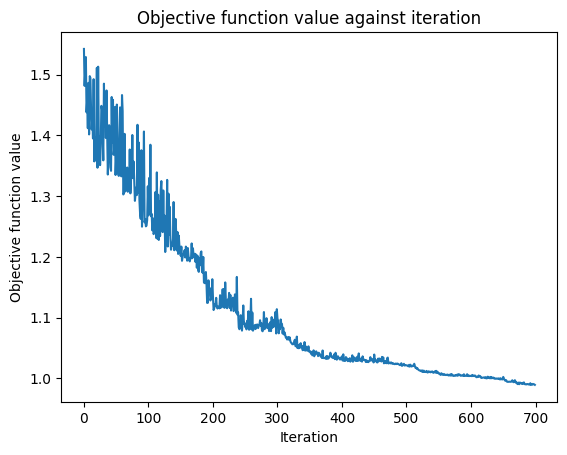

Precision:
 [0.925925925925926]
Accuracy:
 [0.8888888888888888]
Recall:
 [0.9047619047619048]
F1:
 [0.8944855967078189]
Time:
 [970.856837272644]
Mean Precision: 0.925925925925926±0.0
Mean Accuracy: 0.8888888888888888±0.0
Mean Recall: 0.9047619047619048±0.0
Mean F1: 0.8944855967078189±0.0
Mean Time: 970.856837272644±0.0


In [7]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(1):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 700
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=4, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")
#   0.9065476190476189±0.05988284575251499

# **EfficientSU2/PauliTwoDesign**

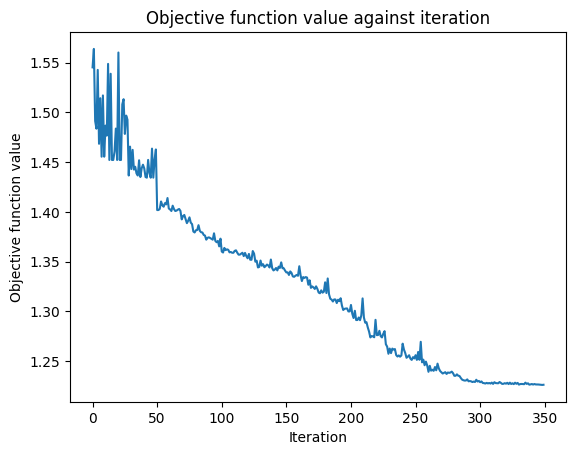

Precision:
 [0.8418300653594771]
Accuracy:
 [0.8055555555555556]
Recall:
 [0.8154761904761906]
F1:
 [0.8033522068117674]
Time:
 [298.49571466445923]


In [15]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(1):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 350
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=3)




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)

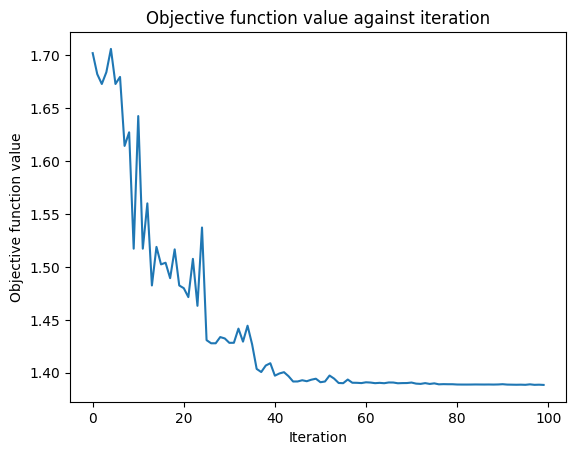

Precision:
 [0.5274509803921569, 0.6479302832244008, 0.5656565656565656, 0.4857174988753936, 0.5056980056980057, 0.5689207306854366, 0.7446581196581197, 0.7568850902184237, 0.6348039215686274, 0.687675364758698]
Accuracy:
 [0.5, 0.6666666666666666, 0.4444444444444444, 0.4444444444444444, 0.5, 0.4444444444444444, 0.6944444444444444, 0.6111111111111112, 0.5277777777777778, 0.6944444444444444]
Recall:
 [0.5535714285714285, 0.6071428571428571, 0.5059523809523809, 0.5059523809523809, 0.48214285714285715, 0.4702380952380952, 0.7202380952380952, 0.6666666666666666, 0.5416666666666666, 0.7202380952380952]
F1:
 [0.4649380048361373, 0.6450788942446339, 0.43040935672514613, 0.40329218106995884, 0.5022996853062213, 0.4561728395061728, 0.6814814814814815, 0.6006897585844954, 0.5433048433048433, 0.6859694989106755]
Time:
 [64.40184378623962, 66.2641270160675, 66.03260660171509, 65.88148164749146, 66.07434177398682, 66.06748247146606, 65.93575859069824, 66.39943623542786, 66.37581086158752, 66.460956

In [7]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 100
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=1)




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")
  
  

Precision:
 [0.5274509803921569, 0.6479302832244008, 0.5656565656565656, 0.4857174988753936, 0.5056980056980057, 0.5689207306854366, 0.7446581196581197, 0.7568850902184237, 0.6348039215686274, 0.687675364758698]
Accuracy:
 [0.5, 0.6666666666666666, 0.4444444444444444, 0.4444444444444444, 0.5, 0.4444444444444444, 0.6944444444444444, 0.6111111111111112, 0.5277777777777778, 0.6944444444444444]
Recall:
 [0.5535714285714285, 0.6071428571428571, 0.5059523809523809, 0.5059523809523809, 0.48214285714285715, 0.4702380952380952, 0.7202380952380952, 0.6666666666666666, 0.5416666666666666, 0.7202380952380952]
F1:
 [0.4649380048361373, 0.6450788942446339, 0.43040935672514613, 0.40329218106995884, 0.5022996853062213, 0.4561728395061728, 0.6814814814814815, 0.6006897585844954, 0.5433048433048433, 0.6859694989106755]
Time:
 [64.40184378623962, 66.2641270160675, 66.03260660171509, 65.88148164749146, 66.07434177398682, 66.06748247146606, 65.93575859069824, 66.39943623542786, 66.37581086158752, 66.46095681190491]
Mean Precision: 0.6125396560735827±0.09193703109511572
Mean Accuracy: 0.5527777777777778±0.09895285072531598
Mean Recall: 0.5773809523809523±0.09070303642285925
Mean F1: 0.5413636543969766±0.10041065581686345
Mean Time: 65.9893845796585±0.5626118659741659


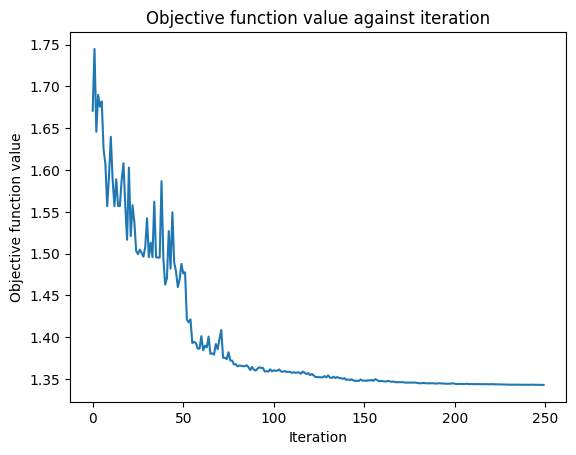

Precision:
 [0.713888888888889, 0.6471661054994389, 0.6284425451092118, 0.734967320261438, 0.7808512293806411, 0.8044662309368191, 0.845679012345679, 0.7756410256410257, 0.7583333333333333, 0.5124320124320124]
Accuracy:
 [0.6944444444444444, 0.5833333333333334, 0.6111111111111112, 0.7222222222222222, 0.7777777777777778, 0.6666666666666666, 0.7777777777777778, 0.6666666666666666, 0.6666666666666666, 0.4722222222222222]
Recall:
 [0.6845238095238094, 0.625, 0.5595238095238095, 0.6904761904761904, 0.7380952380952381, 0.6964285714285715, 0.7916666666666666, 0.6785714285714285, 0.6964285714285715, 0.4583333333333333]
F1:
 [0.6938271604938271, 0.5841223832528182, 0.6191600096828854, 0.7182933553901295, 0.7737432221303189, 0.6828490028490029, 0.7864311390881439, 0.6790123456790123, 0.6805555555555556, 0.48609053497942395]
Time:
 [181.20187377929688, 187.63125038146973, 189.01647806167603, 189.3772008419037, 188.07213878631592, 186.86717820167542, 187.96856904029846, 188.3601152896881, 192.9449

In [8]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 250
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=2)




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")
  
  

Precision:
 [0.713888888888889, 0.6471661054994389, 0.6284425451092118, 0.734967320261438, 0.7808512293806411, 0.8044662309368191, 0.845679012345679, 0.7756410256410257, 0.7583333333333333, 0.5124320124320124]
Accuracy:
 [0.6944444444444444, 0.5833333333333334, 0.6111111111111112, 0.7222222222222222, 0.7777777777777778, 0.6666666666666666, 0.7777777777777778, 0.6666666666666666, 0.6666666666666666, 0.4722222222222222]
Recall:
 [0.6845238095238094, 0.625, 0.5595238095238095, 0.6904761904761904, 0.7380952380952381, 0.6964285714285715, 0.7916666666666666, 0.6785714285714285, 0.6964285714285715, 0.4583333333333333]
F1:
 [0.6938271604938271, 0.5841223832528182, 0.6191600096828854, 0.7182933553901295, 0.7737432221303189, 0.6828490028490029, 0.7864311390881439, 0.6790123456790123, 0.6805555555555556, 0.48609053497942395]
Time:
 [181.20187377929688, 187.63125038146973, 189.01647806167603, 189.3772008419037, 188.07213878631592, 186.86717820167542, 187.96856904029846, 188.3601152896881, 192.94499325752258, 213.68383383750916]
Mean Precision: 0.7201867703828488±0.09393137352828715
Mean Accuracy: 0.663888888888889±0.08735658440842438
Mean Recall: 0.6619047619047619±0.08939675634692498
Mean F1: 0.6704084709101117±0.0844732381019267
Mean Time: 190.51236314773558±8.195682762342969


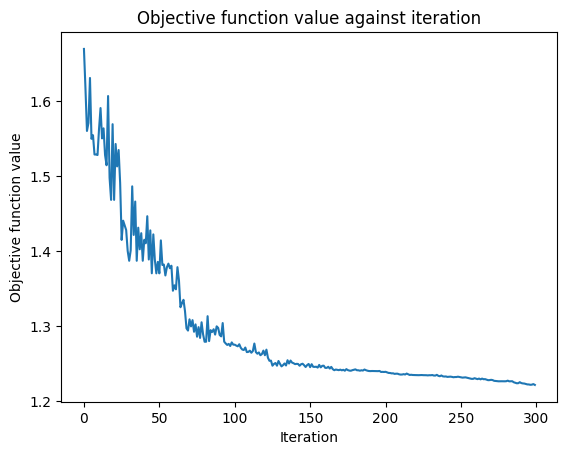

Precision:
 [0.7770833333333333, 0.6496913580246912, 0.7391975308641974, 0.822053872053872, 0.6883040935672515, 0.7477106227106227, 0.72002072002072, 0.7695767195767195, 0.7492063492063491, 0.799074074074074]
Accuracy:
 [0.75, 0.6388888888888888, 0.7222222222222222, 0.75, 0.6388888888888888, 0.75, 0.7222222222222222, 0.7777777777777778, 0.6944444444444444, 0.75]
Recall:
 [0.7321428571428572, 0.6190476190476191, 0.7083333333333334, 0.7857142857142857, 0.6190476190476191, 0.7142857142857143, 0.7619047619047619, 0.7380952380952381, 0.6666666666666666, 0.7142857142857143]
F1:
 [0.7521604938271604, 0.6420051663459372, 0.7279780170246702, 0.7573671497584542, 0.6273849607182941, 0.7465020576131687, 0.7145165858616151, 0.7727330779054917, 0.6973761485270437, 0.74467906820848]
Time:
 [237.80623722076416, 252.53901553153992, 302.6463053226471, 258.165363073349, 257.04598569869995, 255.08129239082336, 225.46972036361694, 195.6241216659546, 194.80242943763733, 194.78491616249084]
Mean Precision: 0

In [10]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 300
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=3)




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")
  
  

Precision:
 [0.7770833333333333, 0.6496913580246912, 0.7391975308641974, 0.822053872053872, 0.6883040935672515, 0.7477106227106227, 0.72002072002072, 0.7695767195767195, 0.7492063492063491, 0.799074074074074]
Accuracy:
 [0.75, 0.6388888888888888, 0.7222222222222222, 0.75, 0.6388888888888888, 0.75, 0.7222222222222222, 0.7777777777777778, 0.6944444444444444, 0.75]
Recall:
 [0.7321428571428572, 0.6190476190476191, 0.7083333333333334, 0.7857142857142857, 0.6190476190476191, 0.7142857142857143, 0.7619047619047619, 0.7380952380952381, 0.6666666666666666, 0.7142857142857143]
F1:
 [0.7521604938271604, 0.6420051663459372, 0.7279780170246702, 0.7573671497584542, 0.6273849607182941, 0.7465020576131687, 0.7145165858616151, 0.7727330779054917, 0.6973761485270437, 0.74467906820848]
Time:
 [237.80623722076416, 252.53901553153992, 302.6463053226471, 258.165363073349, 257.04598569869995, 255.08129239082336, 225.46972036361694, 195.6241216659546, 194.80242943763733, 194.78491616249084]
Mean Precision: 0.7461918673431831±0.048436857451371475
Mean Accuracy: 0.7194444444444444±0.045558942963490924
Mean Recall:0.705952380952381±0.052919311359268736
Mean F1: 0.7182702725790315±0.046646724928050914
Mean Time: 237.3965386867523±33.36822169028627


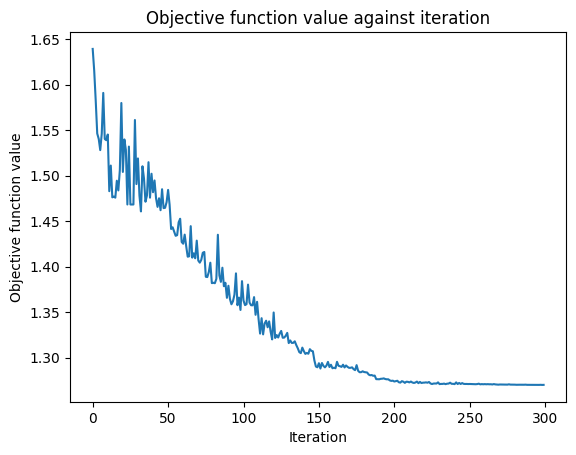

Precision:
 [0.4873737373737374, 0.8555555555555556, 0.6944444444444444, 0.5491228070175438, 0.826851851851852, 0.8186693480811128, 0.6424501424501423, 0.7745098039215687, 0.7877018043684711, 0.654040404040404]
Accuracy:
 [0.4722222222222222, 0.8055555555555556, 0.7222222222222222, 0.5, 0.7777777777777778, 0.8055555555555556, 0.4444444444444444, 0.6944444444444444, 0.7777777777777778, 0.6388888888888888]
Recall:
 [0.4583333333333333, 0.8154761904761906, 0.6547619047619048, 0.48214285714285715, 0.7559523809523809, 0.7797619047619048, 0.4523809523809524, 0.7023809523809524, 0.7380952380952381, 0.6547619047619048]
F1:
 [0.47573099415204684, 0.8085623854739298, 0.6962962962962963, 0.49494949494949503, 0.7801898537192655, 0.8054844398930421, 0.40410052910052907, 0.6936678614097969, 0.7695967869578981, 0.6392397660818714]
Time:
 [310.9451904296875, 286.82136702537537, 286.9935507774353, 282.68440532684326, 244.71298694610596, 240.403311252594, 243.64806938171387, 340.92189621925354, 258.1985

In [5]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 300
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=4)




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")
#   0.6494047619047619±0.13036801433249545
  

Precision:
 [0.4873737373737374, 0.8555555555555556, 0.6944444444444444, 0.5491228070175438, 0.826851851851852, 0.8186693480811128, 0.6424501424501423, 0.7745098039215687, 0.7877018043684711, 0.654040404040404]
Accuracy:
 [0.4722222222222222, 0.8055555555555556, 0.7222222222222222, 0.5, 0.7777777777777778, 0.8055555555555556, 0.4444444444444444, 0.6944444444444444, 0.7777777777777778, 0.6388888888888888]
Recall:
 [0.4583333333333333, 0.8154761904761906, 0.6547619047619048, 0.48214285714285715, 0.7559523809523809, 0.7797619047619048, 0.4523809523809524, 0.7023809523809524, 0.7380952380952381, 0.6547619047619048]
F1:
 [0.47573099415204684, 0.8085623854739298, 0.6962962962962963, 0.49494949494949503, 0.7801898537192655, 0.8054844398930421, 0.40410052910052907, 0.6936678614097969, 0.7695967869578981, 0.6392397660818714]
Time:
 [310.9451904296875, 286.82136702537537, 286.9935507774353, 282.68440532684326, 244.71298694610596, 240.403311252594, 243.64806938171387, 340.92189621925354, 258.1985716819763, 259.1960277557373]
Mean Precision: 0.7090719899104833±0.11841479400817365
Mean Accuracy: 0.663888888888889±0.1352010391515329
Mean Recall: 0.6494047619047619±0.13036801433249545
Mean F1: 0.6567818408034171±0.1411216510888484
Mean Time: 275.4525376796722±30.996090711908572


# **EfficientSU2+Hadamard/PauliTwoDesign**

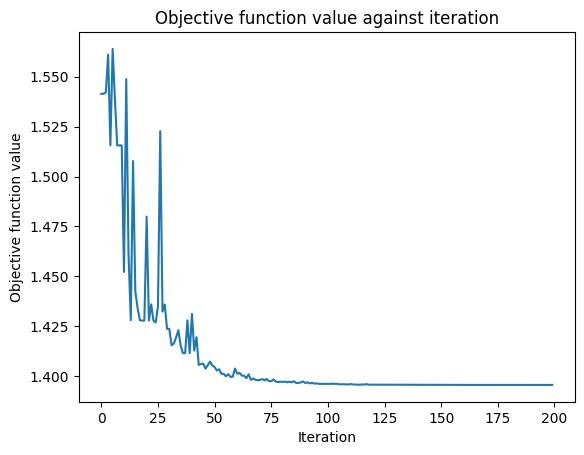

Precision:
 [0.7952798663324979, 0.6494949494949496, 0.7048732943469784, 0.5649405061169768, 0.6226216412490923, 0.7623456790123457, 0.7354808590102707, 0.6027777777777777, 0.7342592592592593, 0.7532163742690059]
Accuracy:
 [0.7777777777777778, 0.6388888888888888, 0.6666666666666666, 0.5833333333333334, 0.6111111111111112, 0.7222222222222222, 0.6944444444444444, 0.5833333333333334, 0.6944444444444444, 0.7222222222222222]
Recall:
 [0.7559523809523809, 0.6547619047619048, 0.7142857142857143, 0.5178571428571429, 0.5952380952380952, 0.7619047619047619, 0.7380952380952381, 0.5714285714285715, 0.7023809523809524, 0.7261904761904763]
F1:
 [0.7697811447811447, 0.6384163473818646, 0.6243487506645402, 0.5707079327151012, 0.607412678332982, 0.6924836601307189, 0.6515237262266125, 0.5902184235517569, 0.6764705882352942, 0.7003367003367003]
Time:
 [132.91048955917358, 146.88607096672058, 158.4295723438263, 121.74146223068237, 122.8683397769928, 116.28125166893005, 123.24391031265259, 120.3784265518

In [11]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 200
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x',
                            su2_gates=['h', 'rz', 'ry'])
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=1)




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")
  
  

Precision:
 [0.7952798663324979, 0.6494949494949496, 0.7048732943469784, 0.5649405061169768, 0.6226216412490923, 0.7623456790123457, 0.7354808590102707, 0.6027777777777777, 0.7342592592592593, 0.7532163742690059]
Accuracy:
 [0.7777777777777778, 0.6388888888888888, 0.6666666666666666, 0.5833333333333334, 0.6111111111111112, 0.7222222222222222, 0.6944444444444444, 0.5833333333333334, 0.6944444444444444, 0.7222222222222222]
Recall:
 [0.7559523809523809, 0.6547619047619048, 0.7142857142857143, 0.5178571428571429, 0.5952380952380952, 0.7619047619047619, 0.7380952380952381, 0.5714285714285715, 0.7023809523809524, 0.7261904761904763]
F1:
 [0.7697811447811447, 0.6384163473818646, 0.6243487506645402, 0.5707079327151012, 0.607412678332982, 0.6924836601307189, 0.6515237262266125, 0.5902184235517569, 0.6764705882352942, 0.7003367003367003]
Time:
 [132.91048955917358, 146.88607096672058, 158.4295723438263, 121.74146223068237, 122.8683397769928, 116.28125166893005, 123.24391031265259, 120.37842655181885, 111.7572271823883, 109.1425428390503]
Mean Precision: 0.6925290206869155±0.07343486835378833
Mean Accuracy: 0.6694444444444445±0.061425956631933266
Mean Recall: 0.6738095238095239±0.0807332468246951
Mean F1: 0.6521699952356717±0.056399475882357455
Mean Time: 126.36392934322357±14.774845548371406


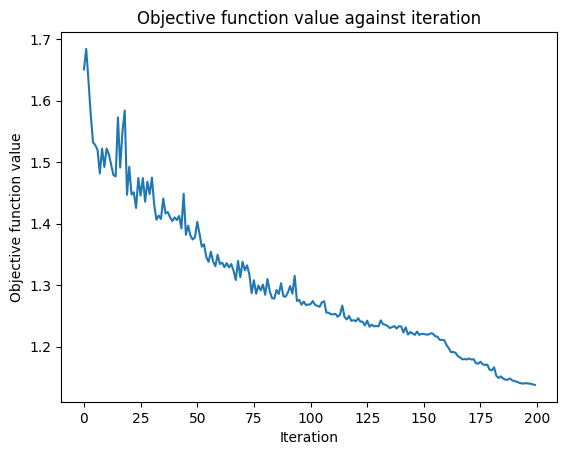

Precision:
 [0.8505644682115271, 0.5243055555555556, 0.7725546058879392, 0.75, 0.8183421516754851, 0.6913250148544265, 0.5626543209876543, 0.7333333333333333, 0.7527777777777778, 0.9266975308641976]
Accuracy:
 [0.8055555555555556, 0.5277777777777778, 0.75, 0.75, 0.7222222222222222, 0.6944444444444444, 0.5555555555555556, 0.7222222222222222, 0.75, 0.9166666666666666]
Recall:
 [0.8154761904761904, 0.5773809523809524, 0.7857142857142857, 0.7142857142857143, 0.7619047619047619, 0.6666666666666666, 0.49404761904761907, 0.6726190476190476, 0.7678571428571429, 0.9285714285714285]
F1:
 [0.7978254531735007, 0.4914141414141414, 0.7393604784909132, 0.75, 0.6747334455667789, 0.6861648745519714, 0.5573845807111527, 0.7071661998132587, 0.7476258309591644, 0.9143355119825708]
Time:
 [153.57791543006897, 157.3321602344513, 159.98757576942444, 156.56374526023865, 161.44642782211304, 150.79829359054565, 122.01098680496216, 121.07957005500793, 145.01763200759888, 158.1568431854248]
Mean Precision: 0.7382

In [5]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 200
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x',
                            su2_gates=['h', 'rz', 'ry'])
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=2)




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")
  
  

Precision:
 [0.8505644682115271, 0.5243055555555556, 0.7725546058879392, 0.75, 0.8183421516754851, 0.6913250148544265, 0.5626543209876543, 0.7333333333333333, 0.7527777777777778, 0.9266975308641976]
Accuracy:
 [0.8055555555555556, 0.5277777777777778, 0.75, 0.75, 0.7222222222222222, 0.6944444444444444, 0.5555555555555556, 0.7222222222222222, 0.75, 0.9166666666666666]
Recall:
 [0.8154761904761904, 0.5773809523809524, 0.7857142857142857, 0.7142857142857143, 0.7619047619047619, 0.6666666666666666, 0.49404761904761907, 0.6726190476190476, 0.7678571428571429, 0.9285714285714285]
F1:
 [0.7978254531735007, 0.4914141414141414, 0.7393604784909132, 0.75, 0.6747334455667789, 0.6861648745519714, 0.5573845807111527, 0.7071661998132587, 0.7476258309591644, 0.9143355119825708]
Time:
 [153.57791543006897, 157.3321602344513, 159.98757576942444, 156.56374526023865, 161.44642782211304, 150.79829359054565, 122.01098680496216, 121.07957005500793, 145.01763200759888, 158.1568431854248]
Mean Precision: 0.7382554759147897±0.11614640957402117
Mean Accuracy: 0.7194444444444444±0.10646537720409333
Mean Recall: 0.718452380952381±0.1172498180862974
Mean F1: 0.7066010516663451±0.11230300143174497
Mean Time: 148.59711501598358±14.256604796647647


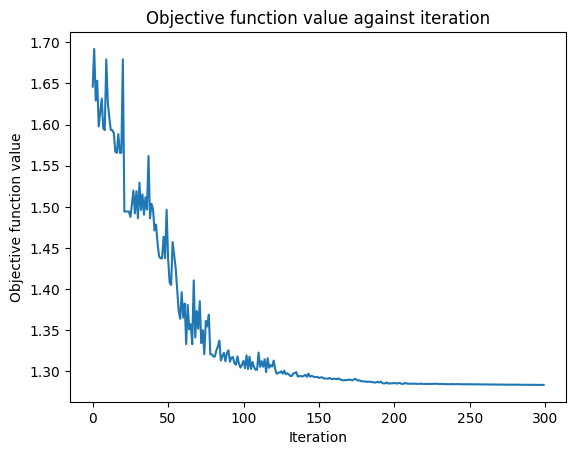

Precision:
 [0.6840277777777778, 0.6666666666666665, 0.7898148148148147, 0.8383190883190883, 0.7296376463043129, 0.7090777051561364, 0.6981481481481481, 0.7845117845117844, 0.8395061728395061, 0.7615740740740741]
Accuracy:
 [0.6944444444444444, 0.6666666666666666, 0.7777777777777778, 0.8333333333333334, 0.7222222222222222, 0.6666666666666666, 0.6944444444444444, 0.6944444444444444, 0.7777777777777778, 0.7222222222222222]
Recall:
 [0.6488095238095238, 0.6428571428571429, 0.7916666666666666, 0.8214285714285715, 0.6726190476190476, 0.6428571428571428, 0.7023809523809524, 0.7023809523809524, 0.8095238095238096, 0.7440476190476191]
F1:
 [0.6859788359788359, 0.6633825944170773, 0.7796771130104463, 0.8348462841926894, 0.7159722222222222, 0.6703721018821533, 0.6623093681917211, 0.6640102434736078, 0.751388888888889, 0.7141414141414142]
Time:
 [267.1950480937958, 222.5836329460144, 216.9746458530426, 268.01633381843567, 266.88213992118835, 268.8884813785553, 259.72458696365356, 272.024156570434

In [9]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 300
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x',
                            su2_gates=['h', 'rz', 'ry'])
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=3)




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")
  
  

Precision:
 [0.6840277777777778, 0.6666666666666665, 0.7898148148148147, 0.8383190883190883, 0.7296376463043129, 0.7090777051561364, 0.6981481481481481, 0.7845117845117844, 0.8395061728395061, 0.7615740740740741]
Accuracy:
 [0.6944444444444444, 0.6666666666666666, 0.7777777777777778, 0.8333333333333334, 0.7222222222222222, 0.6666666666666666, 0.6944444444444444, 0.6944444444444444, 0.7777777777777778, 0.7222222222222222]
Recall:
 [0.6488095238095238, 0.6428571428571429, 0.7916666666666666, 0.8214285714285715, 0.6726190476190476, 0.6428571428571428, 0.7023809523809524, 0.7023809523809524, 0.8095238095238096, 0.7440476190476191]
F1:
 [0.6859788359788359, 0.6633825944170773, 0.7796771130104463, 0.8348462841926894, 0.7159722222222222, 0.6703721018821533, 0.6623093681917211, 0.6640102434736078, 0.751388888888889, 0.7141414141414142]
Time:
 [267.1950480937958, 222.5836329460144, 216.9746458530426, 268.01633381843567, 266.88213992118835, 268.8884813785553, 259.72458696365356, 272.02415657043457, 267.1134488582611, 268.3828241825104]
Mean Precision: 0.750128387861231±0.0589884278449806
Mean Accuracy: 0.725±0.05189317136741503
Mean Recall: 0.7178571428571429±0.06618662201865545
Mean F1: 0.7142079066399056±0.0554439465092378
Mean Time: 257.7785298585892±19.26069752806254


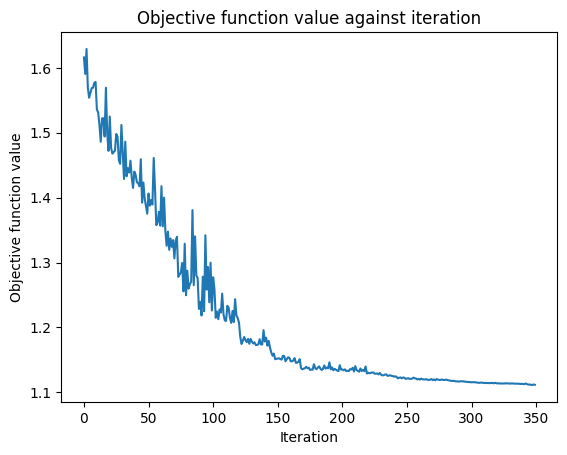

Precision:
 [0.8217592592592592, 0.7473344556677889, 0.7396534792368126, 0.9313725490196079, 0.7106481481481481, 0.623526936026936, 0.7962962962962963, 0.6945006747638327, 0.8836657169990504, 0.8703703703703703]
Accuracy:
 [0.8333333333333334, 0.75, 0.7222222222222222, 0.9166666666666666, 0.6666666666666666, 0.6111111111111112, 0.8055555555555556, 0.6666666666666666, 0.8611111111111112, 0.8611111111111112]
Recall:
 [0.7857142857142857, 0.7678571428571428, 0.7261904761904763, 0.9285714285714285, 0.6607142857142857, 0.6309523809523809, 0.7619047619047619, 0.7142857142857143, 0.8273809523809524, 0.8452380952380952]
F1:
 [0.8232804232804233, 0.7430065359477125, 0.7141028900754302, 0.9156989247311829, 0.6625982042648708, 0.6025086871768794, 0.7974822112753148, 0.6053391053391053, 0.8568969610636278, 0.8646816751391915]
Time:
 [318.6452844142914, 340.1071858406067, 340.5982930660248, 340.4044072628021, 341.7045660018921, 338.55357551574707, 338.40043234825134, 281.3568699359894, 308.76106929

In [5]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 350
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x',
                            su2_gates=['h', 'rz', 'ry'])
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=4)




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")
  
  

Precision:
 [0.8217592592592592, 0.7473344556677889, 0.7396534792368126, 0.9313725490196079, 0.7106481481481481, 0.623526936026936, 0.7962962962962963, 0.6945006747638327, 0.8836657169990504, 0.8703703703703703]
Accuracy:
 [0.8333333333333334, 0.75, 0.7222222222222222, 0.9166666666666666, 0.6666666666666666, 0.6111111111111112, 0.8055555555555556, 0.6666666666666666, 0.8611111111111112, 0.8611111111111112]
Recall:
 [0.7857142857142857, 0.7678571428571428, 0.7261904761904763, 0.9285714285714285, 0.6607142857142857, 0.6309523809523809, 0.7619047619047619, 0.7142857142857143, 0.8273809523809524, 0.8452380952380952]
F1:
 [0.8232804232804233, 0.7430065359477125, 0.7141028900754302, 0.9156989247311829, 0.6625982042648708, 0.6025086871768794, 0.7974822112753148, 0.6053391053391053, 0.8568969610636278, 0.8646816751391915]
Time:
 [318.6452844142914, 340.1071858406067, 340.5982930660248, 340.4044072628021, 341.7045660018921, 338.55357551574707, 338.40043234825134, 281.3568699359894, 308.7610692977905, 339.0408425331116]
Mean Precision: 0.7819127885788102±0.09115830404759558
Mean Accuracy: 0.7694444444444445±0.09626513028424144
Mean Recall: 0.7648809523809523±0.08393701409748207
Mean F1: 0.7585595618293739±0.10515890220593477
Mean Time: 328.7572526216507±19.015590877299516


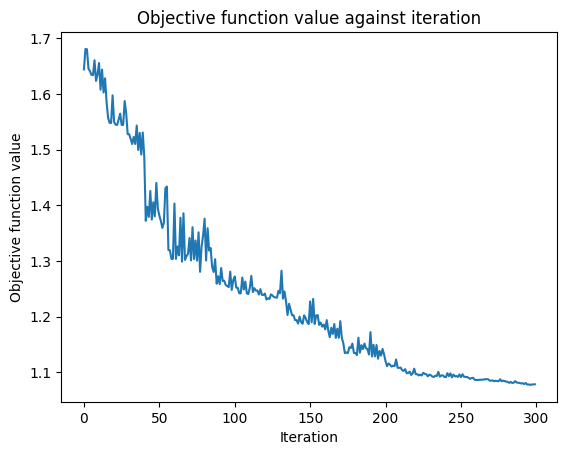

Precision:
 [0.6994301994301995, 0.7349537037037037, 0.7474658869395712, 0.75, 0.8232673961840629, 0.8651234567901234, 0.880718954248366, 0.8630104463437797, 0.8833333333333333, 0.8566448801742919]
Accuracy:
 [0.6666666666666666, 0.7222222222222222, 0.7222222222222222, 0.75, 0.8055555555555556, 0.8611111111111112, 0.8611111111111112, 0.8611111111111112, 0.8333333333333334, 0.8333333333333334]
Recall:
 [0.6964285714285715, 0.6904761904761904, 0.6904761904761904, 0.7321428571428571, 0.8333333333333334, 0.8809523809523809, 0.8630952380952381, 0.8630952380952381, 0.8392857142857143, 0.7857142857142857]
F1:
 [0.6611851201223181, 0.7253561253561254, 0.7187257187257187, 0.75, 0.7947029409271972, 0.8600492363169848, 0.862831541218638, 0.8609900750423626, 0.8320166714028606, 0.8229720265315371]
Time:
 [295.84234976768494, 252.55855512619019, 230.34353637695312, 227.93075323104858, 228.70280241966248, 229.66438007354736, 243.813631772995, 295.45525646209717, 296.41388273239136, 284.9821321964264

In [10]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 300
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x',
                            su2_gates=['h', 'rz', 'ry'])
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=4)




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")
  
  

Precision:
 [0.6994301994301995, 0.7349537037037037, 0.7474658869395712, 0.75, 0.8232673961840629, 0.8651234567901234, 0.880718954248366, 0.8630104463437797, 0.8833333333333333, 0.8566448801742919]
Accuracy:
 [0.6666666666666666, 0.7222222222222222, 0.7222222222222222, 0.75, 0.8055555555555556, 0.8611111111111112, 0.8611111111111112, 0.8611111111111112, 0.8333333333333334, 0.8333333333333334]
Recall:
 [0.6964285714285715, 0.6904761904761904, 0.6904761904761904, 0.7321428571428571, 0.8333333333333334, 0.8809523809523809, 0.8630952380952381, 0.8630952380952381, 0.8392857142857143, 0.7857142857142857]
F1:
 [0.6611851201223181, 0.7253561253561254, 0.7187257187257187, 0.75, 0.7947029409271972, 0.8600492363169848, 0.862831541218638, 0.8609900750423626, 0.8320166714028606, 0.8229720265315371]
Time:
 [295.84234976768494, 252.55855512619019, 230.34353637695312, 227.93075323104858, 228.70280241966248, 229.66438007354736, 243.813631772995, 295.45525646209717, 296.41388273239136, 284.9821321964264]
Mean Precision: 0.8103948257147431±0.06629178202042826
Mean Accuracy: 0.7916666666666666±0.06718548123582127
Mean Recall: 0.7875±0.0742522245938993
Mean F1: 0.7888829455643742±0.06750203063171561
Mean Time: 258.57072801589965±29.319753242810396


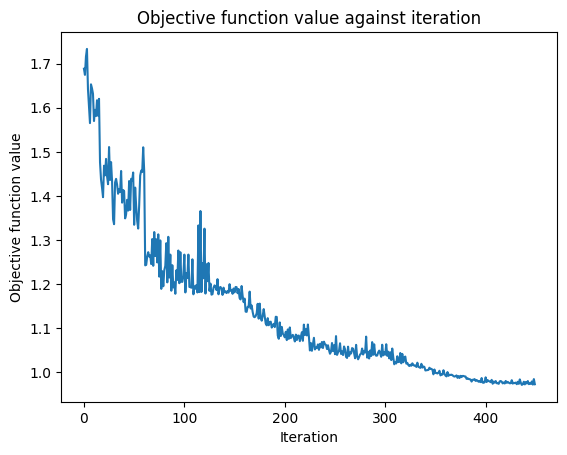

Precision:
 [0.9493827160493827, 0.8892773892773893, 0.8914141414141414, 0.947530864197531, 0.9555555555555555, 0.9145299145299144, 0.9166666666666666, 0.8291666666666667, 0.8638888888888888, 0.9266975308641976]
Accuracy:
 [0.9444444444444444, 0.8611111111111112, 0.8611111111111112, 0.9444444444444444, 0.9444444444444444, 0.8611111111111112, 0.9166666666666666, 0.8333333333333334, 0.7777777777777778, 0.9166666666666666]
Recall:
 [0.9523809523809524, 0.8630952380952381, 0.8630952380952381, 0.9523809523809524, 0.9523809523809524, 0.8809523809523809, 0.9107142857142857, 0.7857142857142857, 0.8095238095238096, 0.9285714285714285]
F1:
 [0.9436036129748098, 0.8683960613785175, 0.8670760233918129, 0.9447470346163157, 0.9465020576131687, 0.8705087505087504, 0.9166666666666666, 0.8215541801748699, 0.787997027127462, 0.9143355119825708]
Time:
 [666.6612904071808, 588.3510189056396, 626.605432510376, 590.4763293266296, 675.2415788173676, 532.7470421791077, 525.8391454219818, 573.6900808811188, 52

In [14]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 450
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=4, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)

  print("Time:\n",times)
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

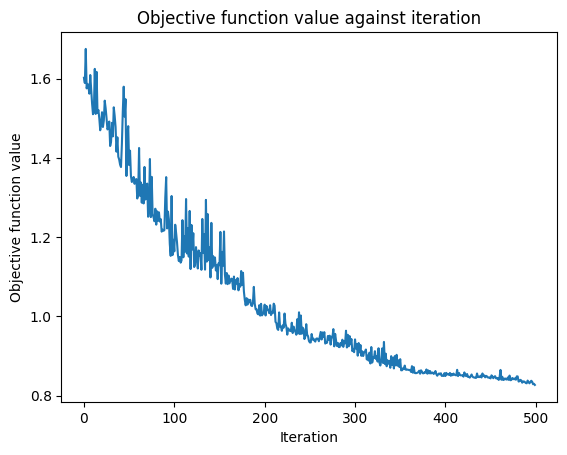

Precision:
 [0.9266975308641976, 0.974074074074074, 0.9116161616161617, 0.974074074074074, 0.8663580246913579, 0.9493827160493827, 0.9493827160493827, 0.8435897435897436, 0.974074074074074, 0.8953703703703704]
Accuracy:
 [0.9166666666666666, 0.9722222222222222, 0.8888888888888888, 0.9722222222222222, 0.8611111111111112, 0.9444444444444444, 0.9444444444444444, 0.8333333333333334, 0.9722222222222222, 0.8888888888888888]
Recall:
 [0.9285714285714285, 0.9761904761904763, 0.9047619047619048, 0.9761904761904763, 0.8630952380952381, 0.9523809523809524, 0.9523809523809524, 0.8392857142857143, 0.9761904761904763, 0.9047619047619048]
F1:
 [0.9143355119825708, 0.9721867461331064, 0.89046783625731, 0.9721867461331064, 0.8607253688389592, 0.9436036129748098, 0.9436036129748098, 0.8353909465020576, 0.9721867461331064, 0.887701804368471]
Time:
 [631.5496368408203, 549.6121146678925, 582.9443497657776, 565.483297586441, 681.1622767448425, 691.8387382030487, 609.070230960846, 796.2019739151001, 818.598

In [9]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 500
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x', 
                            su2_gates=['h', 'ry','rz'] )
  ansatz = TwoLocal(num_qubits=num_qubits, reps=3, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)

  print("Time:\n",times)
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

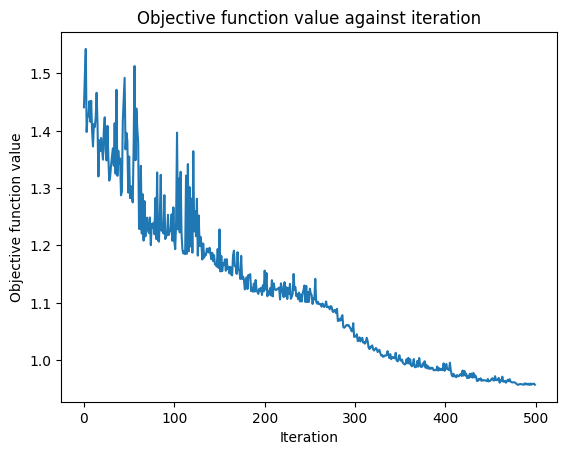

Precision:
 [0.9176163342830009, 0.8682412358882947, 0.974074074074074, 0.9555555555555555, 0.9163817663817664, 0.9246913580246914, 0.9493827160493827, 0.8912037037037036, 0.8330687830687831, 0.8888888888888888]
Accuracy:
 [0.9166666666666666, 0.8611111111111112, 0.9722222222222222, 0.9444444444444444, 0.9166666666666666, 0.9166666666666666, 0.9444444444444444, 0.8888888888888888, 0.8333333333333334, 0.8888888888888888]
Recall:
 [0.9285714285714285, 0.8630952380952381, 0.9761904761904763, 0.9523809523809524, 0.9107142857142857, 0.9107142857142857, 0.9523809523809524, 0.8869047619047619, 0.8214285714285715, 0.8869047619047619]
F1:
 [0.9159404502541757, 0.8568100358422939, 0.9721867461331064, 0.9453941120607787, 0.9156023839931886, 0.9174598221251364, 0.9436036129748098, 0.8864672364672365, 0.831992337164751, 0.8888888888888888]
Time:
 [630.8701448440552, 596.2204608917236, 649.933806180954, 674.7859501838684, 745.7144863605499, 849.2749435901642, 738.304637670517, 664.3498237133026, 913

In [10]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 500
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x', 
                            su2_gates=['h', 'ry','rz'] )
  ansatz = TwoLocal(num_qubits=num_qubits, reps=4, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)

  print("Time:\n",times)
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

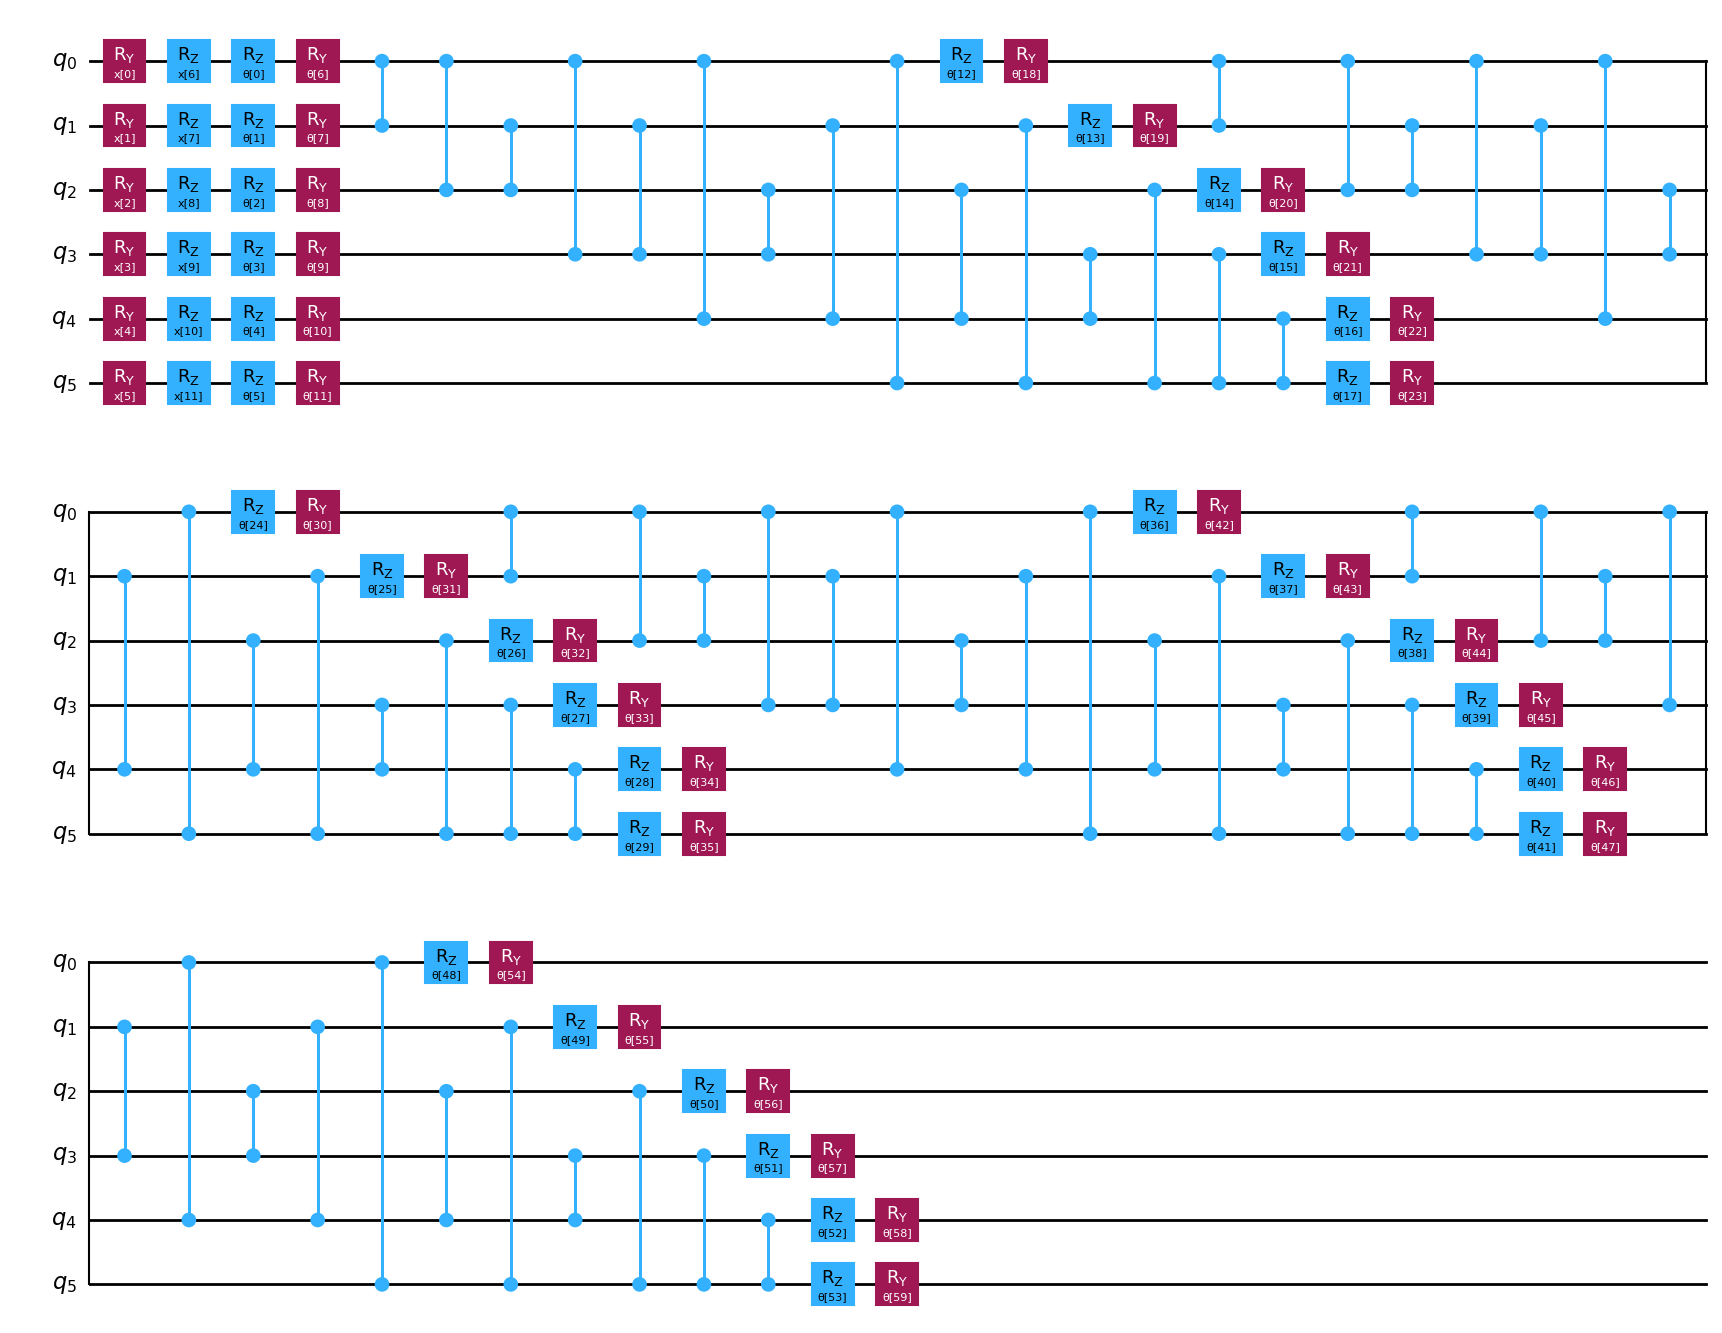

In [8]:
featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x', )
ansatz = TwoLocal(num_qubits=num_qubits, reps=4, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])

qc = QuantumCircuit(num_qubits)
qc.compose(featuremap, inplace=True)
qc.compose(ansatz, inplace=True)
qc.decompose().draw(output="mpl", style='iqx')

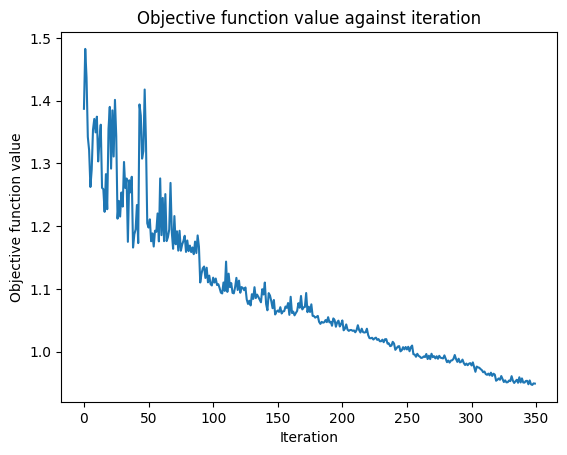

Precision:
 [0.9047619047619047, 0.9055555555555556, 0.9753086419753088, 0.9555555555555555, 0.8484848484848485, 0.9393939393939394, 0.925925925925926, 0.8758169934640523, 0.9145299145299144, 0.9444444444444444]
Accuracy:
 [0.8333333333333334, 0.8888888888888888, 0.9722222222222222, 0.9444444444444444, 0.8333333333333334, 0.9166666666666666, 0.8888888888888888, 0.8611111111111112, 0.8611111111111112, 0.9444444444444444]
Recall:
 [0.8571428571428571, 0.8869047619047619, 0.9761904761904763, 0.9523809523809524, 0.8571428571428571, 0.9285714285714285, 0.9047619047619048, 0.8452380952380952, 0.8809523809523809, 0.9345238095238096]
F1:
 [0.8446645946645945, 0.8929249762583095, 0.9725248123940935, 0.9465020576131687, 0.8315789473684211, 0.9205944586061546, 0.8957264957264957, 0.8601433691756273, 0.8705087505087504, 0.9444444444444444]
Time:
 [450.0323841571808, 436.54948925971985, 401.7457232475281, 364.7313015460968, 345.659770488739, 346.94715428352356, 339.7684404850006, 341.7678806781769,

In [17]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 350
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=3, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)

  print("Time:\n",times)
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.9047619047619047, 0.9055555555555556, 0.9753086419753088, 0.9555555555555555, 0.8484848484848485, 0.9393939393939394, 0.925925925925926, 0.8758169934640523, 0.9145299145299144, 0.9444444444444444]
Accuracy:
 [0.8333333333333334, 0.8888888888888888, 0.9722222222222222, 0.9444444444444444, 0.8333333333333334, 0.9166666666666666, 0.8888888888888888, 0.8611111111111112, 0.8611111111111112, 0.9444444444444444]
Recall:
 [0.8571428571428571, 0.8869047619047619, 0.9761904761904763, 0.9523809523809524, 0.8571428571428571, 0.9285714285714285, 0.9047619047619048, 0.8452380952380952, 0.8809523809523809, 0.9345238095238096]
F1:
 [0.8446645946645945, 0.8929249762583095, 0.9725248123940935, 0.9465020576131687, 0.8315789473684211, 0.9205944586061546, 0.8957264957264957, 0.8601433691756273, 0.8705087505087504, 0.9444444444444444]
Time:
 [450.0323841571808, 436.54948925971985, 401.7457232475281, 364.7313015460968, 345.659770488739, 346.94715428352356, 339.7684404850006, 341.7678806781769, 341.261426448822, 343.9403281211853]


**Mean Precision:** 0.9189777724091449±0.03585928691799313
**Mean Accuracy:** 0.8944444444444445±0.04614791034954483
**Mean Recall:** 0.9345238095238096±0.0
**Mean F1:** 0.897961290676006±0.04477746970188129
**Mean Time:** 371.2403898715973±40.24186106627079


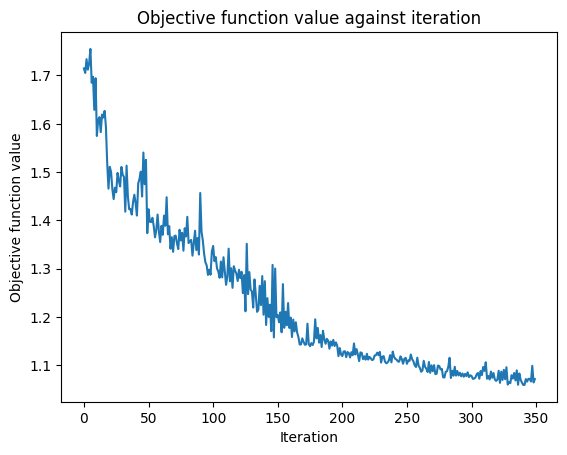

Precision:
 [0.8888888888888888, 0.9493827160493827, 0.8670384399551065, 0.9256410256410257, 0.947530864197531, 0.8888888888888888, 0.9266975308641976, 0.974074074074074, 0.8683501683501683, 0.9266975308641976]
Accuracy:
 [0.8888888888888888, 0.9444444444444444, 0.8611111111111112, 0.9166666666666666, 0.9444444444444444, 0.8888888888888888, 0.9166666666666666, 0.9722222222222222, 0.8611111111111112, 0.9166666666666666]
Recall:
 [0.8869047619047619, 0.9523809523809524, 0.8809523809523809, 0.9285714285714285, 0.9523809523809524, 0.9047619047619048, 0.9285714285714285, 0.9761904761904763, 0.8809523809523809, 0.9285714285714285]
F1:
 [0.8888888888888888, 0.9436036129748098, 0.8572984749455339, 0.9176954732510288, 0.9447470346163157, 0.8888888888888888, 0.9143355119825708, 0.9721867461331064, 0.8573009791400596, 0.9143355119825708]
Time:
 [455.6647045612335, 460.1206350326538, 463.89243030548096, 465.47908329963684, 459.8619394302368, 433.9232807159424, 354.72895860671997, 354.1590638160705

In [7]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 350
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x', su2_gates=['h', 'ry','rz'] )
  ansatz = TwoLocal(num_qubits=num_qubits, reps=3, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)

  print("Time:\n",times)
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

# **EfficientSU2/TwoLocal Test**

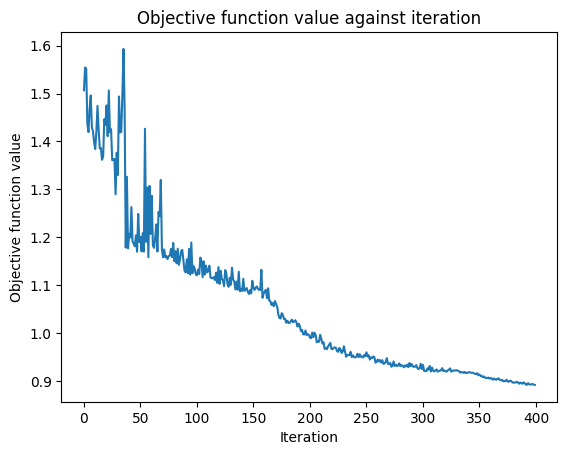

Precision:
 [0.974074074074074]
Accuracy:
 [0.9722222222222222]
Recall:
 [0.9761904761904763]
F1:
 [0.9721867461331064]
Time:
 [435.9503734111786]
Mean Precision: 0.974074074074074±0.0
Mean Accuracy: 0.9722222222222222±0.0
Mean Recall: 0.9761904761904763±0.0
Mean F1: 0.9721867461331064±0.0
Mean Time: 435.9503734111786±0.0


In [9]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(1):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 400
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x', su2_gates=['h', 'ry','rz'] )
  ansatz = TwoLocal(num_qubits=num_qubits, reps=2, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)

  print("Time:\n",times)
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

In [ ]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(1):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 400
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x',
                            su2_gates=['h', 'rz','ry'] )
  ansatz = TwoLocal(num_qubits=num_qubits, reps=2, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)

  print("Time:\n",times)
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

# **Final Comparision between Models**

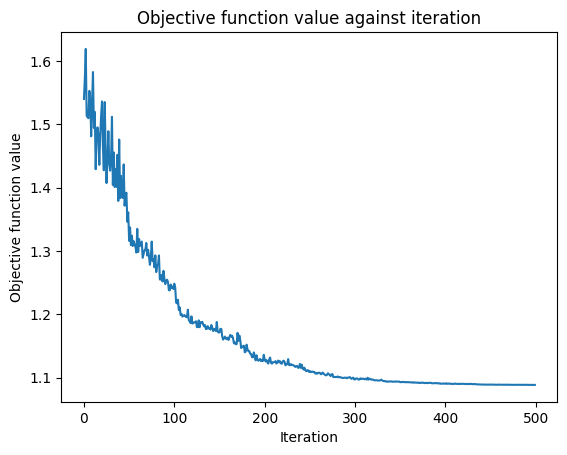

Time:
 [523.367066860199]
Precision:
 [0.83367673992674]
Accuracy:
 [0.8333333333333334]
Recalls:
 [0.8333333333333334]
F1:
 [0.8308641975308642]


In [9]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(1):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)

  
  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 500
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=3)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  score = vqc.score(X_test, Y_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='weighted')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Time:\n",times)
  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)

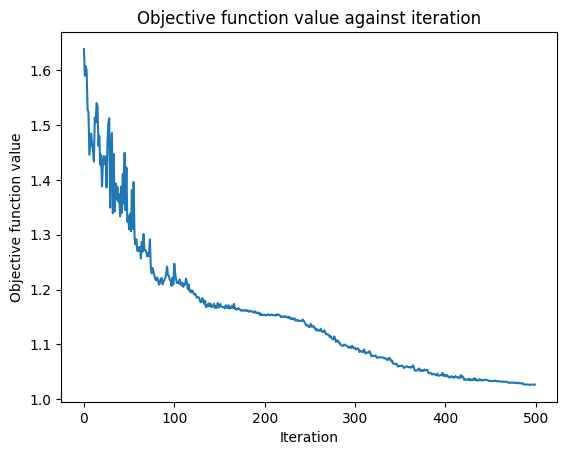

Time:
 [662.1937825679779]
Precision:
 [0.9493827160493827]
Accuracy:
 [0.9444444444444444]
Recalls:
 [0.9444444444444444]
F1:
 [0.9436036129748098]


In [29]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(1):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)

  
  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 500
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x',
                            su2_gates=['h', 'rz','ry'] )
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=4)



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  score = vqc.score(X_test, Y_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='weighted')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Time:\n",times)
  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)

# effsu2_realamp_objective_func_vals = objective_func_vals

In [30]:
effsu2_hadamrd_realamp_objective_func_vals = objective_func_vals

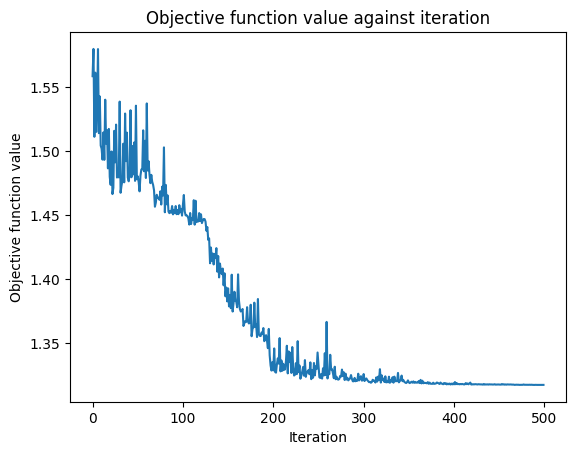

Time:
 [618.1899015903473]
Precision:
 [0.7801898537192655]
Accuracy:
 [0.7777777777777778]
Recalls:
 [0.7777777777777778]
F1:
 [0.7734583218454185]


In [33]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(1):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)

  
  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 500
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x',
                            su2_gates=['h', 'rz','ry'] )
  ansatz = TwoLocal(num_qubits=num_qubits, reps=4, entanglement='cz', rotation_blocks=['rz', "ry"])



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  score = vqc.score(X_test, Y_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='weighted')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Time:\n",times)
  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)

# effsu2_realamp_objective_func_vals = objective_func_vals

In [34]:
effsu2_hadamard_twolocal_objective_func_vals = objective_func_vals

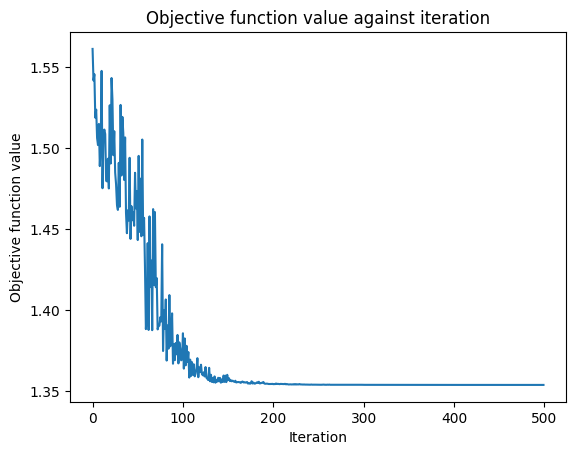

Time:
 [425.19909620285034]
Precision:
 [0.7742424242424243]
Accuracy:
 [0.6666666666666666]
Recalls:
 [0.6666666666666666]
F1:
 [0.6265432098765432]


In [36]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(1):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)

  
  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 500
  num_qubits = X.shape[1]//2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=2, entanglement='cz', rotation_blocks=['rz', "ry"])



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  score = vqc.score(X_test, Y_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='weighted')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Time:\n",times)
  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)

# effsu2_realamp_objective_func_vals = objective_func_vals

In [38]:
effsu2_twolocal_objective_func_vals = objective_func_vals

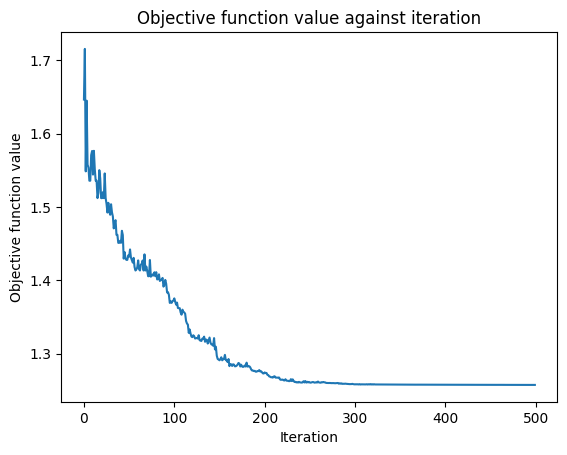

Precision:
 [0.7030303030303029]
Accuracy:
 [0.5]
Recall:
 [0.5357142857142857]
F1:
 [0.5176942355889724]
Time:
 [414.0724790096283]
Mean Precision: 0.7030303030303029±0.0
Mean Accuracy: 0.5±0.0
Mean Recall: 0.5357142857142857±0.0
Mean F1: 0.5176942355889724±0.0
Mean Time: 414.0724790096283±0.0


In [50]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(1):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 500
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=3)




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")
  
  

In [51]:
effsu2_paulidl_objective_func_vals = objective_func_vals

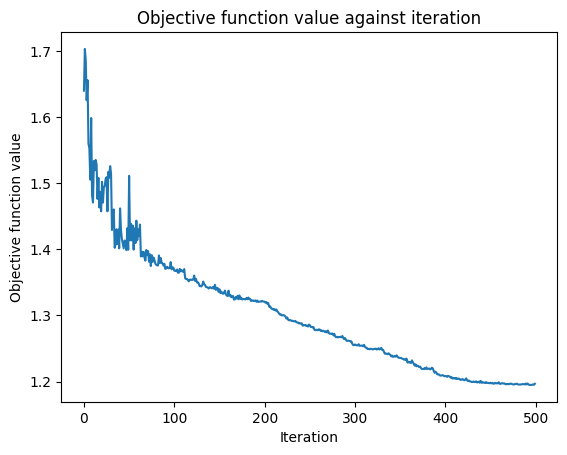

Precision:
 [0.7372685185185186]
Accuracy:
 [0.6944444444444444]
Recall:
 [0.7202380952380952]
F1:
 [0.6882154882154883]
Time:
 [416.3793501853943]
Mean Precision: 0.7372685185185186±0.0
Mean Accuracy: 0.6944444444444444±0.0
Mean Recall: 0.7202380952380952±0.0
Mean F1: 0.6882154882154883±0.0
Mean Time: 416.3793501853943±0.0


In [52]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(1):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 500
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)

  qc_init = QuantumCircuit(num_qubits)

  for i in range(num_qubits):
    qc_init.h(i)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x'
                           ,initial_state=qc_init)
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=4)




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")
  
  

In [53]:
effsu2_paulidl_hadamard_objective_func_vals = objective_func_vals

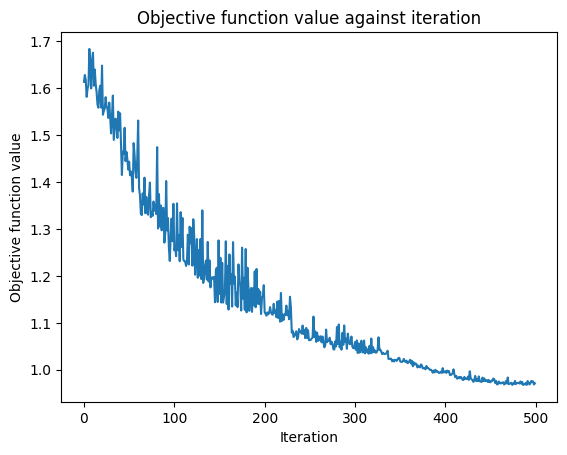

Precision:
 [0.9145502645502646]
Accuracy:
 [0.9166666666666666]
Recall:
 [0.8928571428571429]
F1:
 [0.914367816091954]
Time:
 [733.2001411914825]
Mean Precision: 0.9145502645502646±0.0
Mean Accuracy: 0.9166666666666666±0.0
Mean Recall: 0.8928571428571429±0.0
Mean F1: 0.914367816091954±0.0
Mean Time: 733.2001411914825±0.0


In [58]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(1):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 500
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)
    


  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=4, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
  
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

In [59]:
effsu2_twolocal_objective_func_vals = objective_func_vals

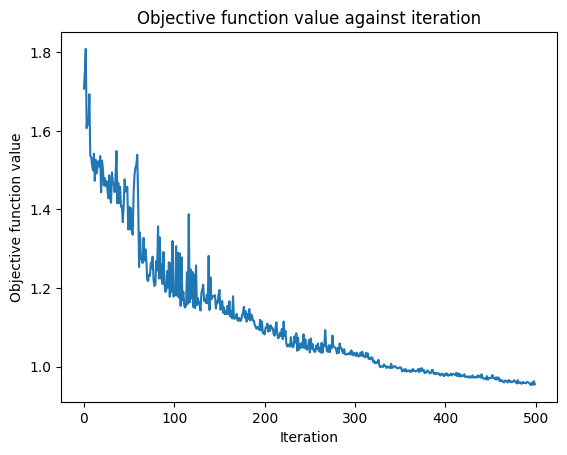

Precision:
 [0.8626984126984127]
Accuracy:
 [0.8611111111111112]
Recall:
 [0.8452380952380952]
F1:
 [0.860727969348659]
Time:
 [697.3187041282654]
Mean Precision: 0.8626984126984127±0.0
Mean Accuracy: 0.8611111111111112±0.0
Mean Recall: 0.8452380952380952±0.0
Mean F1: 0.860727969348659±0.0
Mean Time: 697.3187041282654±0.0


In [55]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(1):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)


  MAXITR = 500
  num_qubits = X.shape[1] //2
  opt = COBYLA(maxiter=MAXITR)
    
  qc_init = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
    qc_init.h(i)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x'
                           ,initial_state=qc_init)
  ansatz = TwoLocal(num_qubits=num_qubits, reps=4, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])




  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)

  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recall:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
  
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

In [56]:
effsu2_hadamard_twolocal_objective_func_vals = objective_func_vals

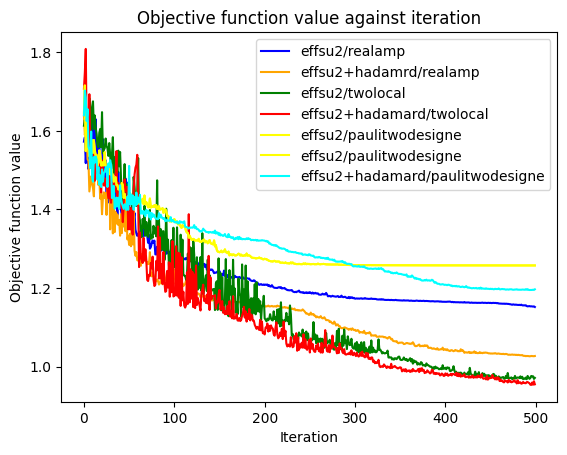

In [60]:
plt.title("Objective function value against iteration")
plt.xlabel("Iteration")
plt.ylabel("Objective function value")

# Colors:
#       Blue
#       Red
#       Green
#       Cyan
#       Magenta
#       Yellow
#       Black
#       White
#       Orange
#       Purple

plt.plot(range(len(effsu2_realamp_objective_func_vals)), 
         effsu2_realamp_objective_func_vals, color='blue', label='effsu2/realamp')
plt.plot(range(len(effsu2_hadamrd_realamp_objective_func_vals)), 
         effsu2_hadamrd_realamp_objective_func_vals, color='orange', 
         label='effsu2+hadamrd/realamp')
plt.plot(range(len(effsu2_twolocal_objective_func_vals)), 
         effsu2_twolocal_objective_func_vals, color='green',
         label='effsu2/twolocal')
plt.plot(range(len(effsu2_hadamard_twolocal_objective_func_vals)), 
         effsu2_hadamard_twolocal_objective_func_vals, color='red',
         label='effsu2+hadamard/twolocal')
plt.plot(range(len(effsu2_paulidl_objective_func_vals)), 
         effsu2_paulidl_objective_func_vals, color='yellow',
         label='effsu2/paulitwodesigne')
plt.plot(range(len(effsu2_paulidl_objective_func_vals)), 
         effsu2_paulidl_objective_func_vals, color='yellow',
         label='effsu2/paulitwodesigne')
plt.plot(range(len(effsu2_paulidl_hadamard_objective_func_vals)), 
         effsu2_paulidl_hadamard_objective_func_vals, color='cyan',
         label='effsu2+hadamard/paulitwodesigne')
effsu2_paulidl_hadamard_objective_func_vals
plt.legend()
plt.show()

In [28]:
effsu2_hadamrd_realamp_objective_func_vals

[1.5727010420519119,
 1.5836003070295408,
 1.5180244506909686,
 1.5679752704174468,
 1.5321354455393035,
 1.5027076760305416,
 1.5178168600688149,
 1.5582697620512547,
 1.5227856990668602,
 1.5562728685137057,
 1.6357619642330938,
 1.4757564480530385,
 1.5730923404312946,
 1.6296568214101108,
 1.5461415052408334,
 1.5193916665414908,
 1.5806166655846272,
 1.5741971483184733,
 1.478722733036686,
 1.5299439411047482,
 1.5172972406224796,
 1.579135077038258,
 1.4760234462934034,
 1.4644896960967424,
 1.5255044695870044,
 1.4175709514441068,
 1.4557154656769407,
 1.4181313292142048,
 1.4457665489398785,
 1.417765511745544,
 1.41550086945494,
 1.404662924769376,
 1.4899557926577458,
 1.4381848870198632,
 1.4216244412604075,
 1.427235640108215,
 1.4551968396776311,
 1.3858199691442945,
 1.4958697518485797,
 1.410123209459714,
 1.4125257415011512,
 1.3981221253749163,
 1.3839457244811781,
 1.4213664211644181,
 1.413345261879544,
 1.4030276340953605,
 1.4788224573548068,
 1.397368318866372,
 1